# IR spectral analysis of organic and coordination compounds via machine learning and neural networks
By: Koshelev Daniil

Based on some code form: https://github.com/rayguna/IR-Spectra-Analyzer
Предыдущая часть: https://github.com/Lamblador/IR_expert_system/blob/main/Koshelev_IR_expert_system_1_Dataset_Preparation.ipynb

-Work in progress (last updated:20/07/2023)-

B. Цель данного блокнота

Целью этого блокнота является обучение примитивной модели распознавания всего лишь 15 классов (функциональных групп) в спектре из 1800 точек в диапазоне 500-4100 [1/cm] c аугментацией датасета разными способами.

C. План реализации

1. Импортировать табличные данные разметки классов по CAS и табличные данные уже обработанных спектров нужного диапазона.
2. Протестировать различные способы аугментации


NOTES
1. Импортированы табличные данные.
2. Протестированы аугментации шумом и добавлением фона
3. Тестируется нормирование трейнового датасета

Клонирование данных с GitHub. На сайте выложены как исходные списки веществ, так и скачанные спектры соединений, которые были запарсены ранее.

In [ ]:
!git clone https://github.com/Lamblador/IR_expert_system.git

Cloning into 'IR_expert_system'...
remote: Enumerating objects: 17572, done.
remote: Counting objects: 100% (2729/2729), done.
remote: Compressing objects: 100% (2493/2493), done.
remote: Total 17572 (delta 241), reused 2713 (delta 230), pack-reused 14843
Receiving objects: 100% (17572/17572), 2.14 GiB | 9.41 MiB/s, done.
Resolving deltas: 100% (601/601), done.
Updating files: 100% (17201/17201), done.


In [ ]:
# Установка нужных пакетов
from IPython.core.display import clear_output
!pip install torchmetrics
clear_output()

In [ ]:
# Вводятся нужные импорты
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torch.nn as nn

In [ ]:
import random
from torchvision import datasets, transforms


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

# Импорт табличных данных

In [ ]:
#Считывание датасета
def read_dataset(dataset_name):
  '''
  Function for reading dataset into pandas Dataframe from /IR_expert_system/data/datasets/

  dataset_name - name of dataset's folder to read

  return pd.Dataframe with whole dataset

  parameters:
      name = ['dataset3']
          dataset3 - dataset made from reading most of jcam files, with padded y, interpolated x and peak layer. Saved in 10 pieces.
  '''
  df_list = []
  # choose current directory
  curr_directory = os.getcwd()
  os.chdir(curr_directory)  # set to current directory
  files = glob.glob('/content/IR_expert_system/data/datasets/'+dataset_name+'/*.pkl')  # look for files without extension. Returns a list.
  # Try to read the file. If can't be read, skip it.
  #print(files)
  for i, file in tqdm(enumerate(files)):
      df = pd.read_pickle(file)
      df_list.append(df)
  #print(df_list)
  result = pd.concat(df_list)
  return result

dataset_df_readed = read_dataset('dataset4')
dataset_df_readed

10it [00:03,  3.23it/s]


index                                           title jcamp-dx  \
7170    1140-14-3                    Benzophenone, 2,4,-dimethyl-     4.24   
7171   40061-45-8                               PHENACYL PYRAZINE     4.24   
7172     928-95-0                              2-Hexen-1-ol, (E)-     4.24   
7173    2364-54-7            5-Methyl-4-nitroso-2-isopropylphenol     4.24   
7174   15544-47-5  BENZENESULFONAMIDE, N,N'-BUTYLENEBIS[4-METHYL-     4.24   
...           ...                                             ...      ...   
11467   1195-59-1                        PYRIDINE, 2,6-DICARBINOL     4.24   
11468    122-07-6               2,2-Dimethoxy-N-methyl-ethanamine     4.24   
11469     80-30-8             4-Toluenesulfonamide, N-cyclohexyl-     4.24   
11470   2050-99-9                       5-Nonanone, 2,8-dimethyl-     4.24   
11471  92291-24-2        PURINE, 6-AZIRIDINYL-9-BENZYL-8-CHLORO-,     4.24   

               data type                                             origin  \
7170   INFRARED SPECTRUM     K. K. DEB-NCI FREDERICK CANCER RESEARCH CENTER   
7171   INFRARED SPECTRUM  WYANDOTTE CHEMICALS CORP., WYANDOTTE, MICHIGAN...   
7172   INFRARED SPECTRUM        Sadtler Research Labs Under US-EPA Contract   
7173   INFRARED SPECTRUM                         EPA-IR VAPOR PHASE LIBRARY   
7174   INFRARED SPECTRUM                        SOUTHERN RESEARCH INSTITUTE   
...                  ...                                                ...   
11467  INFRARED SPECTRUM                               DOW CHEMICAL COMPANY   
11468  INFRARED SPECTRUM                         EPA-IR VAPOR PHASE LIBRARY   
11469  INFRARED SPECTRUM                               DOW CHEMICAL COMPANY   
11470  INFRARED SPECTRUM        Sadtler Research Labs Under US-EPA Contract   
11471  INFRARED SPECTRUM                            SOUTHERN RESEARCH INST.   

                                                   owner cas registry no  \
7170   Copyright (C) 1987 by the Coblentz Society\nCo...       1140-14-3   
7171   COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...      40061-45-8   
7172   NIST Standard Reference Data Program\nCollecti...        928-95-0   
7173   SRD/NIST\nCollection (C) 2018 copyright by the...       2364-54-7   
7174   COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...      15544-47-5   
...                                                  ...             ...   
11467  COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...       1195-59-1   
11468  SRD/NIST\nCollection (C) 2018 copyright by the...        122-07-6   
11469  Copyright (C) 1987 by the Coblentz Society\nCo...         80-30-8   
11470  NIST Standard Reference Data Program\nCollecti...       2050-99-9   
11471  COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...      92291-24-2   

                molform $nist source  \
7170          C15 H14 O     COBLENTZ   
7171       C12 H10 N2 O     COBLENTZ   
7172         C 6 H 12 O      MSDC-IR   
7173    C 10 H 13 N O 2      MSDC-IR   
7174   C18 H24 N2 O4 S2     COBLENTZ   
...                 ...          ...   
11467        C7 H9 N O2     COBLENTZ   
11468    C 5 H 13 N O 2      MSDC-IR   
11469    C13 H19 N O2 S     COBLENTZ   
11470       C 11 H 22 O      MSDC-IR   
11471     C14 H12 Cl N5     COBLENTZ   

                                spectrometer/data system  ...  \
7170                          PERKIN-ELMER 180 (GRATING)  ...   
7171   Not specified, most likely a prism, grating, o...  ...   
7172                                                 NaN  ...   
7173                                                 NaN  ...   
7174                          PERKIN-ELMER 221 (GRATING)  ...   
...                                                  ...  ...   
11467  Not specified, most likely a prism, grating, o...  ...   
11468                                                NaN  ...   
11469                              DOW FOREPRISM-GRATING  ...   
11470                                                NaN  ...   
11471            

In [ ]:
labels_df = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_inchi_group_list.csv')
labels_df = labels_df.set_index("CAS")
labels_df

Name      Formula  \
CAS                                                                       
100-00-5                        Benzene, 1-chloro-4-nitro-    C6H4ClNO2   
100-01-6                                    p-Nitroaniline     C6H6N2O2   
100-02-7                                  Phenol, 4-nitro-      C6H5NO3   
1000-49-3                           N-butyltrimethylsilane      C7H18Si   
1000-50-6                      N-Butyldimethylchlorosilane    C6H15ClSi   
...                                                    ...          ...   
99-97-8                      Benzenamine, N,N,4-trimethyl-       C9H13N   
999-78-0                          2-Pentyne, 4,4-dimethyl-        C7H12   
999-81-5        Ammonium chloride, 2-chloroethyltrimethyl-  C5H13ClN.Cl   
99-99-0                         Benzene, 1-methyl-4-nitro-      C7H7NO2   
999-97-3   Silanamine, 1,1,1-trimethyl-N-(trimethylsilyl)-    C6H19NSi2   

                   Mw                     Elements  \
CAS                                                  
100-00-5   156.993056   ['C', 'H', 'Cl', 'N', 'O']   
100-01-6   138.042927         ['C', 'H', 'N', 'O']   
100-02-7   139.026943         ['C', 'H', 'N', 'O']   
1000-49-3  130.117777             ['C', 'H', 'Si']   
1000-50-6  150.063155       ['C', 'H', 'Cl', 'Si']   
...               ...                          ...   
99-97-8    135.104799              ['C', 'H', 'N']   
999-78-0    96.093900                   ['C', 'H']   
999-81-5   157.042505  ['C', 'H', 'Cl', 'N', 'Cl']   
99-99-0    137.047678         ['C', 'H', 'N', 'O']   
999-97-3   161.105603        ['C', 'H', 'N', 'Si']   

                                                       InChi  \
CAS                                                            
100-00-5     InChI=1/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H   
100-01-6   InChI=1/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H...   
100-02-7     InChI=1/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H   
1000-49-3      InChI=1/C7H18Si/c1-5-6-7-8(2,3)4/h5-7H2,1-4H3   
1000-50-6    InChI=1/C6H15ClSi/c1-4-5-6-8(2,3)7/h4-6H2,1-3H3   
...                                                      ...   
99-97-8    InChI=1/C9H13N/c1-8-4-6-9(7-5-8)10(2)3/h4-7H,1...   
999-78-0                 InChI=1/C7H12/c1-5-6-7(2,3)4/h1-4H3   
999-81-5   InChI=1/C5H13ClN.ClH/c1-7(2,3)5-4-6;/h4-5H2,1-...   
99-99-0    InChI=1/C7H7NO2/c1-6-2-4-7(5-3-6)8(9)10/h2-5H,1H3   
999-97-3      InChI=1/C6H19NSi2/c1-8(2,3)7-9(4,5)6/h7H,1-6H3   

                             SMILES  alkane  methyl  alkene  alkyne  ...  \
CAS                                                                  ...   
100-00-5   [O-][N+](=O)c1ccc(Cl)cc1     0.0     0.0     0.0     0.0  ...   
100-01-6    Nc1ccc(cc1)[N+]([O-])=O     0.0     0.0     0.0     0.0  ...   
100-02-7    Oc1ccc(cc1)[N+]([O-])=O     0.0     0.0     0.0     0.0  ...   
1000-49-3           CCCC[Si](C)(C)C     1.0     1.0     0.0     0.0  ...   
1000-50-6          CCCC[Si](C)(C)Cl     1.0     1.0     0.0     0.0  ...   
...                             ...     ...     ...     ...     ...  ...   
99-97-8            CN(C)c1ccc(C)cc1     0.0     1.0     0.0     0.0  ...   
999-78-0               CC#CC(C)(C)C     1.0     1.0     0.0     1.0  ...   
999-81-5      [Cl-].C[N+](C)(C)CCCl     1.0     1.0     0.0     0.0  ...   
99-99-0     Cc1ccc(cc1)[N+]([O-])=O     0.0     1.0     0.0     0.0  ...   
999-97-3    C[Si](C)(C)N[Si](C)(C)C     0.0     1.0     0.0     0.0  ...   

           aromatics  alkyl halides  esters  ketones  aldehydes  \
CAS                                                               
100-00-5         1.0            1.0     0.0      0.0        0.0   
100-01-6         1.0            0.0     0.0      0.0        0.0   
100-02-7         1.0            0.0     0.0      0.0        0.0   
1000-49-3        0.0            0.0     0.0      0.0        0.0   
1000-50-6        0.0            0.0     0.0      0.0        0.0   
...              ...            ...     ...      ...        ...   
99-97-8          

In [ ]:
dataset_df_readed = dataset_df_readed.set_index('index')

In [ ]:
dataset_df_labeled = labels_df.join(dataset_df_readed)
#dataset_df_labeled

In [ ]:
dataset_df_labeled.columns

Index(['Name', 'Formula', 'Mw', 'Elements', 'InChi', 'SMILES', 'alkane',
       'methyl', 'alkene', 'alkyne',
       ...
       'number of interferograms averaged per single channel spectrum',
       '$spectra version', '$uncertainty in y', 'sample description',
       'pressure', 'temperature', 'x1', 'y1', 'y_peak', 'x_peak'],
      dtype='object', length=102)

In [ ]:
dataset_df_labeled1 = dataset_df_labeled[['Name', 'Formula', 'Mw', 'Elements', 'InChi', 'SMILES', 'alkane',
       'methyl', 'alkene', 'alkyne', 'alcohols', 'amines', 'nitriles',
       'aromatics', 'alkyl halides', 'esters', 'ketones', 'aldehydes',
       'carboxylic acids', 'ether', 'acyl halides', 'amides', 'nitro',
       'title',
       'molform',
       'x', 'y', 'x1', 'y1', 'y_peak']]
dataset_df_labeled1

Name      Formula  \
CAS                                                                       
100-00-5                        Benzene, 1-chloro-4-nitro-    C6H4ClNO2   
100-01-6                                    p-Nitroaniline     C6H6N2O2   
100-02-7                                  Phenol, 4-nitro-      C6H5NO3   
1000-49-3                           N-butyltrimethylsilane      C7H18Si   
1000-50-6                      N-Butyldimethylchlorosilane    C6H15ClSi   
...                                                    ...          ...   
99-97-8                      Benzenamine, N,N,4-trimethyl-       C9H13N   
999-78-0                          2-Pentyne, 4,4-dimethyl-        C7H12   
999-81-5        Ammonium chloride, 2-chloroethyltrimethyl-  C5H13ClN.Cl   
99-99-0                         Benzene, 1-methyl-4-nitro-      C7H7NO2   
999-97-3   Silanamine, 1,1,1-trimethyl-N-(trimethylsilyl)-    C6H19NSi2   

                   Mw                     Elements  \
CAS                                                  
100-00-5   156.993056   ['C', 'H', 'Cl', 'N', 'O']   
100-01-6   138.042927         ['C', 'H', 'N', 'O']   
100-02-7   139.026943         ['C', 'H', 'N', 'O']   
1000-49-3  130.117777             ['C', 'H', 'Si']   
1000-50-6  150.063155       ['C', 'H', 'Cl', 'Si']   
...               ...                          ...   
99-97-8    135.104799              ['C', 'H', 'N']   
999-78-0    96.093900                   ['C', 'H']   
999-81-5   157.042505  ['C', 'H', 'Cl', 'N', 'Cl']   
99-99-0    137.047678         ['C', 'H', 'N', 'O']   
999-97-3   161.105603        ['C', 'H', 'N', 'Si']   

                                                       InChi  \
CAS                                                            
100-00-5     InChI=1/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H   
100-01-6   InChI=1/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H...   
100-02-7     InChI=1/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H   
1000-49-3      InChI=1/C7H18Si/c1-5-6-7-8(2,3)4/h5-7H2,1-4H3   
1000-50-6    InChI=1/C6H15ClSi/c1-4-5-6-8(2,3)7/h4-6H2,1-3H3   
...                                                      ...   
99-97-8    InChI=1/C9H13N/c1-8-4-6-9(7-5-8)10(2)3/h4-7H,1...   
999-78-0                 InChI=1/C7H12/c1-5-6-7(2,3)4/h1-4H3   
999-81-5   InChI=1/C5H13ClN.ClH/c1-7(2,3)5-4-6;/h4-5H2,1-...   
99-99-0    InChI=1/C7H7NO2/c1-6-2-4-7(5-3-6)8(9)10/h2-5H,1H3   
999-97-3      InChI=1/C6H19NSi2/c1-8(2,3)7-9(4,5)6/h7H,1-6H3   

                             SMILES  alkane  methyl  alkene  alkyne  ...  \
CAS                                                                  ...   
100-00-5   [O-][N+](=O)c1ccc(Cl)cc1     0.0     0.0     0.0     0.0  ...   
100-01-6    Nc1ccc(cc1)[N+]([O-])=O     0.0     0.0     0.0     0.0  ...   
100-02-7    Oc1ccc(cc1)[N+]([O-])=O     0.0     0.0     0.0     0.0  ...   
1000-49-3           CCCC[Si](C)(C)C     1.0     1.0     0.0     0.0  ...   
1000-50-6          CCCC[Si](C)(C)Cl     1.0     1.0     0.0     0.0  ...   
...                             ...     ...     ...     ...     ...  ...   
99-97-8            CN(C)c1ccc(C)cc1     0.0     1.0     0.0     0.0  ...   
999-78-0               CC#CC(C)(C)C     1.0     1.0     0.0     1.0  ...   
999-81-5      [Cl-].C[N+](C)(C)CCCl     1.0     1.0     0.0     0.0  ...   
99-99-0     Cc1ccc(cc1)[N+]([O-])=O     0.0     1.0     0.0     0.0  ...   
999-97-3    C[Si](C)(C)N[Si](C)(C)C     0.0     1.0     0.0     0.0  ...   

           acyl halides  amides  nitro  \
CAS                                      
100-00-5            0.0     0.0    1.0   
100-01-6            0.0     0.0    1.0   
100-02-7            0.0     0.0    1.0   
1000-49-3           0.0     0.0    0.0   
1000-50-6           0.0     0.0    0.0   
...                 ...     ...    ...   
99-97-8             0.0     0.0    0.0   
999-78-0            0.0     0.0    0.0   
999-81-5            0.0     0.0    0.0   
99-99-0             0.0     0.0    1.0   
999-97-3            0.0     0.0    0.0   

      

In [ ]:
spectra_x =dataset_df_labeled1.iloc[:,-1]
spectra_x_t = torch.Tensor(spectra_x[0])
spectra_x_t

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [ ]:
len(dataset_df_labeled1.iloc[:,-3][0])

1800

# Разделение DataFrame на test и train

Разделение исходного датасета на train, test, val в соотношении 7/2/1. Поскольку аугментация должна происходить только для train датасета.

In [ ]:
dataset_df_labeled1 = dataset_df_labeled1.dropna()
dataset_df_labeled1_suffled = dataset_df_labeled1.sample(frac=1)
fraction_test = 0.1
fraction_val = 0.2
length = len(dataset_df_labeled1_suffled)
dataset_df_labeled1_test = dataset_df_labeled1_suffled.iloc[:round(length*fraction_test)]
dataset_df_labeled1_val = dataset_df_labeled1_suffled.iloc[round(length*fraction_test):round(length*(fraction_val+fraction_test))]
dataset_df_labeled1_train = dataset_df_labeled1_suffled.iloc[round(length*(fraction_val+fraction_test)):]
print(len(dataset_df_labeled1_test), len(dataset_df_labeled1_val), len(dataset_df_labeled1_train))

1193 2387 8354


Визуализируем исходный датасет и раздение, для отсутствия перекосов в данных.

In [ ]:
def dataset_sum_vis(dataset):
  sum = dataset.sum()
  sum1 = sum[7:-5]
  df = pd.DataFrame(sum1)
  # plot
  ax = df.plot(kind='bar', figsize=(5, 2), title='Count',
             xlabel='Counts', ylabel='Classess', legend=False)
  # annotate
  ax.bar_label(ax.containers[0], label_type='edge')
  # pad the spacing between the number and the edge of the figure
  ax.margins(y=0.1)

<ipython-input-14-c3597b5d4cc0>:2: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sum = dataset.sum()
<ipython-input-14-c3597b5d4cc0>:2: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sum = dataset.sum()
<ipython-input-14-c3597b5d4cc0>:2: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sum = dataset.sum()


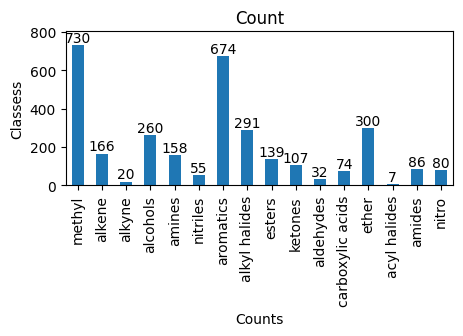

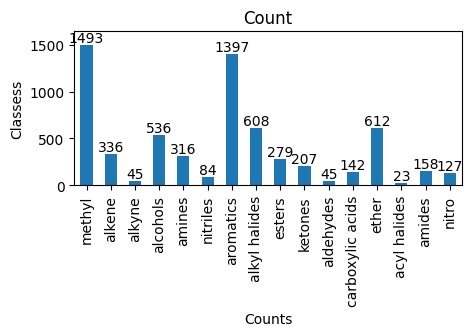

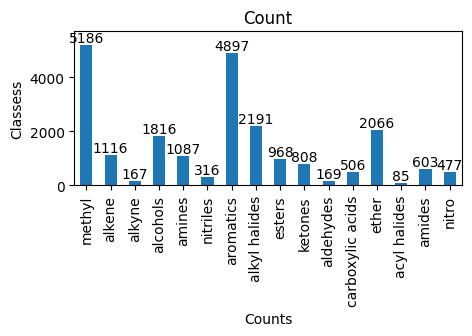

In [ ]:
dataset_sum_vis(dataset_df_labeled1_test)
dataset_sum_vis(dataset_df_labeled1_val)
dataset_sum_vis(dataset_df_labeled1_train)

# Аугментация

In [ ]:
import numpy as np

class GaussNoiseAdd(object):
    """Add to the spectra gauss noise.

    Args:
        strength = strength of the noise in fraction of max height ()
    """

    def __init__(self, strength):
        #assert isinstance(output_size, (int, tuple))
        self.strength = strength

    def __call__(self, sample):
        mean = 0
        x = np.array(sample[0])
        y = np.array(sample[1])
        z = np.array(sample[2])
        var = self.strength*max(y)
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(len(y)))
        y_gauss = y+gauss
        if len(sample) == 2:
          output = [x, y_gauss]
        elif len(sample) == 3:
          output = [x, y_gauss, z]
        output = torch.Tensor(np.concatenate(output, axis=0))
        return output

In [ ]:
import numpy as np

class LinearAdd(object):
    """Add to the spectra linear func.

    Args:
        slope = slope of the linear function to add.
    """

    def __init__(self, slope):
        #assert isinstance(output_size, (int, tuple))
        self.slope = slope

    def __call__(self, sample):
        mean = 0
        x = np.array(sample[0])
        y = np.array(sample[1])
        z = np.array(sample[2])
        n = abs(np.random.normal())
        add = x*self.slope*n
        y_add = y+add
        if len(sample) == 2:
          output = [x, y_add]
        elif len(sample) == 3:
          output = [x, y_add, z]
        output = torch.Tensor(np.concatenate(output, axis=0))
        return output

In [ ]:
import numpy as np

class NormalizeSpectra(object):
    """Normalize spectra with mean and std.

    Args:
        mean = Tensor of floats
        std = Tensor of floats.
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
      output = []
      # print(len(sample))
      # print(len(sample[0]))
      # print(self.mean[0])
      # print(self.std[0])
      sample = torch.Tensor(sample)
      for i in range(len(sample)):
        output.append(torch.sub(sample[i], self.mean[i])*self.std[i])
      output = torch.stack(output)
      output = torch.Tensor(output)
      return output

## Аугментация датасета

In [104]:
dataset_df_labeled2 = dataset_df_labeled1_train.dropna().reset_index()

In [105]:
#Рассчитываем редкость каждого спектра, чтобы не дуплицировать
#лишнего спектры с частыми классами
wts = dataset_df_labeled2.describe().loc['mean'].drop(['Mw']).to_numpy()
labels = dataset_df_labeled2.iloc[:,7:-7].to_numpy()
rarity = pd.Series(np.dot(labels, wts))
dataset_df_labeled3 = dataset_df_labeled2
dataset_df_labeled3['rarity']=rarity

In [106]:
dataset_df_labeled4 = dataset_df_labeled3[dataset_df_labeled3.rarity != 0].sort_values('rarity')
dataset_df_labeled4.rarity.describe()

count    8300.000000
mean        1.451682
std         0.480654
min         0.019990
25%         1.077089
50%         1.469236
75%         1.761910
max         2.845463
Name: rarity, dtype: float64

Получается, что нужно размножить только от 25 до 50% спектров, для аугментирования самых редких.

In [107]:
dataset_df_labeled5 = dataset_df_labeled4

In [108]:
from tqdm import tqdm
def augmentate_dataset(dataset, transform, quartile = 0.25):
  '''
  Function to augmentate dataset with one or several transforms

  argumetns:
    dataset - pandas DataFrame - dataset to augmentate
    transform - function - method of augmentation (get x,y,z; return x, new_y,z)
    quartile - float - fraction of dataset to augmentate
  '''
  num_new_spc = round(len(dataset)*quartile)
  for i in tqdm(range(num_new_spc)):
    indx_new_spc = len(dataset)+i
    copy = dataset.iloc[i].copy()
    dataset.loc[indx_new_spc] = copy
    x = dataset.loc[indx_new_spc].loc['x1'].copy()
    y = dataset.loc[indx_new_spc].loc['y1'].copy()
    z = dataset.loc[indx_new_spc].loc['y_peak'].copy()
    t_data = transform([x,y,z]) #
    x_new, y_new, z_new = t_data[0], t_data[1], t_data[2]
    dataset.loc[indx_new_spc].loc['x1'] = x_new
    dataset.loc[indx_new_spc].loc['y1'] = y_new
    dataset.loc[indx_new_spc].loc['y_peak'] = z_new
  return dataset

In [ ]:
pd.options.mode.chained_assignment = None

In [ ]:
#ВЫПОЛНЯТЬ ТОЛЬКО 1 РАЗ! Если не хотите повторяющихся спектров.
dataset_df_labeled6 = augmentate_dataset(dataset_df_labeled5, GaussNoiseAdd(0.00001), quartile = 0.30)
dataset_df_labeled7 = augmentate_dataset(dataset_df_labeled5, LinearAdd(0.00001), quartile = 0.30)
dataset_df_labeled7

100%|██████████| 3221/3221 [00:57<00:00, 55.85it/s]


CAS                       Name   Formula          Mw  \
6194      74-86-2                  Acetylene      C2H2   26.015650   
192      107-22-2                 Ethanedial    C2H2O2   58.005479   
4314     592-85-8       Mercuric thiocyanate  C2HgN2S2  311.916123   
5712    1070-71-9            Propiolonitrile      C3HN   51.010899   
7375      87-39-8              Violuric acid  C4H3N3O4  157.012356   
...           ...                        ...       ...         ...   
17169  32749-94-3    Pentanal, 2,3-dimethyl-    C7H14O  114.104465   
17171    110-62-3                   Pentanal    C5H10O   86.073165   
17173     97-96-1          Butanal, 2-ethyl-    C6H12O  100.088815   
17175    123-72-8                    Butanal     C4H8O   72.057515   
17177   2987-16-8  3,3-Dimethylbutyraldehyde    C6H12O  100.088815   

                    Elements  \
6194              ['C', 'H']   
192          ['C', 'H', 'O']   
4314   ['C', 'Hg', 'N', 'S']   
5712         ['C', 'H', 'N']   
7375    ['C', 'H', 'N', 'O']   
...                      ...   
17169        ['C', 'H', 'O']   
17171        ['C', 'H', 'O']   
17173        ['C', 'H', 'O']   
17175        ['C', 'H', 'O']   
17177        ['C', 'H', 'O']   

                                                   InChi  \
6194                             InChI=1/C2H2/c1-2/h1-2H   
192                        InChI=1/C2H2O2/c3-1-2-4/h1-2H   
4314   InChI=1/4CHNS.Hg.2K/c4*2-1-3;;;/h4*3H;;;/q;;;;...   
5712                           InChI=1/C3HN/c1-2-3-4/h1H   
7375   InChI=1/C4H3N3O4/c8-2-1(7-11)3(9)6-4(10)5-2/h1...   
...                                                  ...   
17169    InChI=1/C7H14O/c1-4-6(2)7(3)5-8/h5-7H,4H2,1-3H3   
17171          InChI=1/C5H10O/c1-2-3-4-5-6/h5H,2-4H2,1H3   
17173    InChI=1/C6H12O/c1-3-6(4-2)5-7/h5-6H,3-4H2,1-2H3   
17175             InChI=1/C4H8O/c1-2-3-4-5/h4H,2-3H2,1H3   
17177        InChI=1/C6H12O/c1-6(2,3)4-5-7/h5H,4H2,1-3H3   

                                                 SMILES  alkane  methyl  \
6194                                                C#C     0.0     0.0   
192                                              O=CC=O     0.0     0.0   
4314   [K+].[K+].[Hg++].[S-]C#N.[S-]C#N.[S-]C#N.[S-]C#N     0.0     0.0   
5712                                             C#CC#N     0.0     0.0   
7375                              ON=C1C(=O)NC(=O)NC1=O     0.0     0.0   
...                                                 ...     ...     ...   
17169                                     CCC(C)C(C)C=O     1.0     1.0   
17171                                           CCCCC=O     1.0     1.0   
17173                                        CCC(CC)C=O     1.0     1.0   
17175                                            CCCC=O     1.0     1.0   
17177                                      CC(C)(C)CC=O     1.0     1.0   

       alkene  ...  amides  nitro                 title       molform  \
6194      0.0  ...     0.0    0.0             Acetylene       C 2 H 2   
192       0.0  ...     0.0    0.0      Glyoxal solution   C 2 H 2 O 2   
4314      0.0  ...     0.0    0.0  MERCURIC THIOCYANATE  Hg ( S C N)2   
5712      0.0  ...     0.0    0.0        Cyanoacetylene       C 3 H N   
7375      0.0  ...     1.0    0.0         VIOLURIC ACID   C4 H3 N3 O4   
...       ...  ...     ...    ...                   ...           ...   
17169     0.0  ...     0.0    0.0  2,3-Dimethylpentanal    C 7 H 14 O   
17171     0.0  ...     0.0    0.0              Pentanal    C 5 H 10 O   
17173     0.0  ...     0.0    0.0     Butanal, 2-ethyl-    C 6 H 12 O   
17175     0.0  ...     0.0    0.0               Butanal     C 4 H 8 O   
17177     0.0  ...     0.0    0.0   2,2-Dimethylbutanal    C 6 H 12 O   

                                                       x  \
6194   [450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...   
192    [499.4778, 499.96167, 500.44333, 500.925, 501....   
4314   [625.54736, 625.81604, 626.08356, 626.35126, 6...   
5712   [550.0, 554.0, 558.0, 562.0, 566.0, 570.0,

<ipython-input-26-7802d3c26f76>:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sum = dataset_df_labeled7.sum()


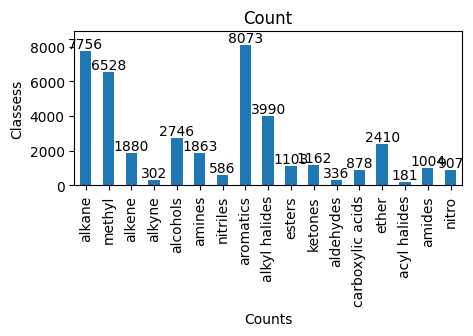

In [ ]:
sum = dataset_df_labeled7.sum()
sum1 = sum[7:-6]
df = pd.DataFrame(sum1)
# plot
ax = df.plot(kind='bar', figsize=(5, 2), title='Count',
           xlabel='Counts', ylabel='Classess', legend=False)
# annotate
ax.bar_label(ax.containers[0], label_type='edge')
# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

In [ ]:
dataset_df_labeled_gl5 = dataset_df_labeled7.drop(['rarity'], axis = 1)
dataset_df_labeled_gl5

CAS                       Name   Formula          Mw  \
6194      74-86-2                  Acetylene      C2H2   26.015650   
192      107-22-2                 Ethanedial    C2H2O2   58.005479   
4314     592-85-8       Mercuric thiocyanate  C2HgN2S2  311.916123   
5712    1070-71-9            Propiolonitrile      C3HN   51.010899   
7375      87-39-8              Violuric acid  C4H3N3O4  157.012356   
...           ...                        ...       ...         ...   
17169  32749-94-3    Pentanal, 2,3-dimethyl-    C7H14O  114.104465   
17171    110-62-3                   Pentanal    C5H10O   86.073165   
17173     97-96-1          Butanal, 2-ethyl-    C6H12O  100.088815   
17175    123-72-8                    Butanal     C4H8O   72.057515   
17177   2987-16-8  3,3-Dimethylbutyraldehyde    C6H12O  100.088815   

                    Elements  \
6194              ['C', 'H']   
192          ['C', 'H', 'O']   
4314   ['C', 'Hg', 'N', 'S']   
5712         ['C', 'H', 'N']   
7375    ['C', 'H', 'N', 'O']   
...                      ...   
17169        ['C', 'H', 'O']   
17171        ['C', 'H', 'O']   
17173        ['C', 'H', 'O']   
17175        ['C', 'H', 'O']   
17177        ['C', 'H', 'O']   

                                                   InChi  \
6194                             InChI=1/C2H2/c1-2/h1-2H   
192                        InChI=1/C2H2O2/c3-1-2-4/h1-2H   
4314   InChI=1/4CHNS.Hg.2K/c4*2-1-3;;;/h4*3H;;;/q;;;;...   
5712                           InChI=1/C3HN/c1-2-3-4/h1H   
7375   InChI=1/C4H3N3O4/c8-2-1(7-11)3(9)6-4(10)5-2/h1...   
...                                                  ...   
17169    InChI=1/C7H14O/c1-4-6(2)7(3)5-8/h5-7H,4H2,1-3H3   
17171          InChI=1/C5H10O/c1-2-3-4-5-6/h5H,2-4H2,1H3   
17173    InChI=1/C6H12O/c1-3-6(4-2)5-7/h5-6H,3-4H2,1-2H3   
17175             InChI=1/C4H8O/c1-2-3-4-5/h4H,2-3H2,1H3   
17177        InChI=1/C6H12O/c1-6(2,3)4-5-7/h5H,4H2,1-3H3   

                                                 SMILES  alkane  methyl  \
6194                                                C#C     0.0     0.0   
192                                              O=CC=O     0.0     0.0   
4314   [K+].[K+].[Hg++].[S-]C#N.[S-]C#N.[S-]C#N.[S-]C#N     0.0     0.0   
5712                                             C#CC#N     0.0     0.0   
7375                              ON=C1C(=O)NC(=O)NC1=O     0.0     0.0   
...                                                 ...     ...     ...   
17169                                     CCC(C)C(C)C=O     1.0     1.0   
17171                                           CCCCC=O     1.0     1.0   
17173                                        CCC(CC)C=O     1.0     1.0   
17175                                            CCCC=O     1.0     1.0   
17177                                      CC(C)(C)CC=O     1.0     1.0   

       alkene  ...  acyl halides  amides  nitro                 title  \
6194      0.0  ...           0.0     0.0    0.0             Acetylene   
192       0.0  ...           0.0     0.0    0.0      Glyoxal solution   
4314      0.0  ...           0.0     0.0    0.0  MERCURIC THIOCYANATE   
5712      0.0  ...           0.0     0.0    0.0        Cyanoacetylene   
7375      0.0  ...           0.0     1.0    0.0         VIOLURIC ACID   
...       ...  ...           ...     ...    ...                   ...   
17169     0.0  ...           0.0     0.0    0.0  2,3-Dimethylpentanal   
17171     0.0  ...           0.0     0.0    0.0              Pentanal   
17173     0.0  ...           0.0     0.0    0.0     Butanal, 2-ethyl-   
17175     0.0  ...           0.0     0.0    0.0               Butanal   
17177     0.0  ...           0.0     0.0    0.0   2,2-Dimethylbutanal   

            molform                                                  x  \
6194        C 2 H 2  [450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...   
192     C 2 H 2 O 2  [499.4778, 499.96167, 500.44333, 500.925, 501....   
4314   Hg ( S C N)2  [625.54736, 625.81604, 626.08356, 626.35126, 6

## Нормирование датасета

In [ ]:
# # Расчёт среднего и дисперсии по выборке
total_sum = torch.tensor([0.0, 0.0])
total_sum_square = torch.tensor([0.0, 0.0])

for i in tqdm(range(len(dataset_df_labeled7))):
    y = dataset_df_labeled7.iloc[i]['y1']
    y_peak = dataset_df_labeled7.iloc[i]['y_peak']
    spectra = torch.stack((torch.Tensor(y), torch.Tensor(y_peak)))
    total_sum += spectra.sum(axis = [1])
    total_sum_square += (spectra ** 2).sum(axis = [1])

count = len(dataset_df_labeled7) * len(dataset_df_labeled7.iloc[0]['y'])
# mean and std
total_mean = total_sum / count
total_var  = (total_sum_square / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)
#Ранее рассчитано по функции выше
#ВНИМАНИЕ! Требуется расчёта требуется предварительное создение класса датасет без трансформации!
total_mean = torch.Tensor(total_mean)
total_std = torch.Tensor(total_std)
# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))


100%|██████████| 13958/13958 [00:04<00:00, 2942.72it/s]

mean: tensor([0.2311, 0.2656])
std:  tensor([0.2334, 0.3318])


In [ ]:
y1n = []
z1n = []
for i in tqdm(range(len(dataset_df_labeled7))):
  yn = torch.sub(torch.Tensor(dataset_df_labeled7.iloc[i]['y1']), total_mean[0])*total_std[0]
  zn = torch.sub(torch.Tensor(dataset_df_labeled7.iloc[i]['y_peak']), total_mean[1])*total_std[1]
  y1n.append(yn.numpy())
  z1n.append(zn.numpy())

100%|██████████| 13958/13958 [00:05<00:00, 2364.89it/s]


In [ ]:
y1n_s = pd.Series(y1n)
z1n_s = pd.Series(z1n)
print(y1n_s)

0        [-0.051991127, -0.052241217, -0.0525783, -0.05...
1        [0.017571336, 0.012510572, 0.0042386674, -0.00...
2        [0.052498277, 0.052498277, 0.052498277, 0.0524...
3        [-0.053701714, -0.053701714, -0.053701714, -0....
4        [0.09918064, 0.09918064, 0.09918064, 0.0991806...
                               ...                        
13953    [-0.053790715, -0.053790715, -0.053790715, -0....
13954    [-0.045793794, -0.04487356, -0.044825125, -0.0...
13955    [-0.052683465, -0.05266779, -0.05263644, -0.05...
13956    [-0.048569012, -0.048055507, -0.047250237, -0....
13957    [-0.053879645, -0.053879645, -0.053879645, -0....
Length: 13958, dtype: object


In [ ]:
dataset_df_labeled8 = dataset_df_labeled7.reset_index()

In [ ]:
dataset_df_labeled8 = dataset_df_labeled8.drop(['index'], axis=1)
dataset_df_labeled8['y1n'] = y1n_s
dataset_df_labeled8['z1n'] = z1n_s
#dataset_df_labeled8

In [ ]:
dataset_df_labeled9 = dataset_df_labeled8.reset_index()
dataset_df_labeled9 = dataset_df_labeled9.drop(['index', 'rarity', 'Mw', 'Elements'], axis=1)
dataset_df_labeled9

CAS                       Name   Formula  \
0         74-86-2                  Acetylene      C2H2   
1        107-22-2                 Ethanedial    C2H2O2   
2        592-85-8       Mercuric thiocyanate  C2HgN2S2   
3       1070-71-9            Propiolonitrile      C3HN   
4         87-39-8              Violuric acid  C4H3N3O4   
...           ...                        ...       ...   
13953  32749-94-3    Pentanal, 2,3-dimethyl-    C7H14O   
13954    110-62-3                   Pentanal    C5H10O   
13955     97-96-1          Butanal, 2-ethyl-    C6H12O   
13956    123-72-8                    Butanal     C4H8O   
13957   2987-16-8  3,3-Dimethylbutyraldehyde    C6H12O   

                                                   InChi  \
0                                InChI=1/C2H2/c1-2/h1-2H   
1                          InChI=1/C2H2O2/c3-1-2-4/h1-2H   
2      InChI=1/4CHNS.Hg.2K/c4*2-1-3;;;/h4*3H;;;/q;;;;...   
3                              InChI=1/C3HN/c1-2-3-4/h1H   
4      InChI=1/C4H3N3O4/c8-2-1(7-11)3(9)6-4(10)5-2/h1...   
...                                                  ...   
13953    InChI=1/C7H14O/c1-4-6(2)7(3)5-8/h5-7H,4H2,1-3H3   
13954          InChI=1/C5H10O/c1-2-3-4-5-6/h5H,2-4H2,1H3   
13955    InChI=1/C6H12O/c1-3-6(4-2)5-7/h5-6H,3-4H2,1-2H3   
13956             InChI=1/C4H8O/c1-2-3-4-5/h4H,2-3H2,1H3   
13957        InChI=1/C6H12O/c1-6(2,3)4-5-7/h5H,4H2,1-3H3   

                                                 SMILES  alkane  methyl  \
0                                                   C#C     0.0     0.0   
1                                                O=CC=O     0.0     0.0   
2      [K+].[K+].[Hg++].[S-]C#N.[S-]C#N.[S-]C#N.[S-]C#N     0.0     0.0   
3                                                C#CC#N     0.0     0.0   
4                                 ON=C1C(=O)NC(=O)NC1=O     0.0     0.0   
...                                                 ...     ...     ...   
13953                                     CCC(C)C(C)C=O     1.0     1.0   
13954                                           CCCCC=O     1.0     1.0   
13955                                        CCC(CC)C=O     1.0     1.0   
13956                                            CCCC=O     1.0     1.0   
13957                                      CC(C)(C)CC=O     1.0     1.0   

       alkene  alkyne  alcohols  ...  nitro                 title  \
0         0.0     1.0       0.0  ...    0.0             Acetylene   
1         0.0     0.0       0.0  ...    0.0      Glyoxal solution   
2         0.0     0.0       0.0  ...    0.0  MERCURIC THIOCYANATE   
3         0.0     1.0       0.0  ...    0.0        Cyanoacetylene   
4         0.0     0.0       0.0  ...    0.0         VIOLURIC ACID   
...       ...     ...       ...  ...    ...                   ...   
13953     0.0     0.0       0.0  ...    0.0  2,3-Dimethylpentanal   
13954     0.0     0.0       0.0  ...    0.0              Pentanal   
13955     0.0     0.0       0.0  ...    0.0     Butanal, 2-ethyl-   
13956     0.0     0.0       0.0  ...    0.0               Butanal   
13957     0.0     0.0       0.0  ...    0.0   2,2-Dimethylbutanal   

            molform                                                  x  \
0           C 2 H 2  [450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...   
1       C 2 H 2 O 2  [499.4778, 499.96167, 500.44333, 500.925, 501....   
2      Hg ( S C N)2  [625.54736, 625.81604, 626.08356, 626.35126, 6...   
3           C 3 H N  [550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...   
4       C4 H3 N3 O4  [628.49207, 628.7616, 629.0327, 629.30414, 629...   
...             ...                                                ...   
13953    C 7 H 14 O  [550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...   
13954    C 5 H 10 O  [450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...   
13955    C 6 H 12 O  [450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...   
13956     C 4 H 8 O  [450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...   
13957    C 6 H 12 O  [550.0, 554.0, 558.0, 562.0, 56

# Создание класса Dataset

In [ ]:
#Класс датасета на 17 классов со входом формата (2,1800)
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets

class IRSpectraDataset(Dataset):
    def __init__(self, dataset_df_labeled):
        self.dataset_df = dataset_df_labeled
        self.spectra_labels = self.dataset_df.iloc[:,6:23]
        self.spectra_x = self.dataset_df.iloc[:,-3]
        self.spectra_y = self.dataset_df.iloc[:,-2]

    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx):

        spectra_x = torch.Tensor(self.spectra_x.iloc[idx]).reshape((1, 1800))
        spectra_y = torch.Tensor(self.spectra_y.iloc[idx]).reshape((1, 1800))
        spectra = torch.cat((spectra_x, spectra_y))

        label = torch.Tensor(self.spectra_labels.iloc[idx])
        #transform
        return spectra, label

In [ ]:
#Класс датасета на 17 классов со входом формата (3,1800) +вход максимумов
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets

class IRSpectraDatasetP(Dataset):
    def __init__(self, dataset_df_labeled, transforms = None):
        self.dataset_df = dataset_df_labeled
        self.spectra_labels = self.dataset_df.iloc[:,6:23]
        self.spectra_x = self.dataset_df.iloc[:,-3]
        self.spectra_y = self.dataset_df.iloc[:,-2]
        self.spectra_y_peak = self.dataset_df.iloc[:,-1]
        self.transform = transforms

    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx):

        spectra_x = torch.Tensor(self.spectra_x.iloc[idx]).reshape((1, 1800))
        spectra_y = torch.Tensor(self.spectra_y.iloc[idx]).reshape((1, 1800))
        spectra_y_peak = torch.Tensor(self.spectra_y_peak.iloc[idx]).reshape((1, 1800))
        spectra = torch.cat((spectra_x, spectra_y, spectra_y_peak))
        if self.transform:
            #print(spectra)
            spectra = self.transform(spectra)
        label = torch.Tensor(self.spectra_labels.iloc[idx])
        #transform
        return spectra, label

In [ ]:
#Класс датасета на 17 классов со входом формата (4,1800)+вход максимумов+вход положений полос
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets

class IRSpectraDatasetPA(Dataset):
    def __init__(self, dataset_df_labeled, df_cls_attention):
        self.dataset_df = dataset_df_labeled
        self.df_cls_attention = df_cls_attention
        self.spectra_labels = self.dataset_df.iloc[:,6:23]
        self.spectra_x = self.dataset_df.iloc[:,-3]
        self.spectra_y = self.dataset_df.iloc[:,-2]
        self.spectra_y_peak = self.dataset_df.iloc[:,-1]

    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx):

        spectra_x = torch.Tensor(self.spectra_x.iloc[idx]).reshape((1, 1800))
        spectra_y = torch.Tensor(self.spectra_y.iloc[idx]).reshape((1, 1800))
        spectra_y_peak = torch.Tensor(self.spectra_y_peak.iloc[idx]).reshape((1, 1800))
        class_attention = torch.Tensor(self.df_cls_attention).reshape((1, 1800))
        spectra = torch.cat((spectra_x, spectra_y, spectra_y_peak, class_attention))

        label = torch.Tensor(self.spectra_labels.iloc[idx])
        #transform
        return spectra, label

In [ ]:
#Класс датасета на 17 классов со входом формата (2,1800) +вход максимумов нормированный
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets

class IRSpectraDatasetPN(Dataset):
    def __init__(self, dataset_df_labeled, transforms = None):
        self.dataset_df = dataset_df_labeled
        self.spectra_labels = self.dataset_df.iloc[:,6:23]
        #self.spectra_x = self.dataset_df.iloc[:,-3]
        self.spectra_y = self.dataset_df.iloc[:,-2]
        self.spectra_y_peak = self.dataset_df.iloc[:,-1]
        self.transform = transforms

    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx):

        #spectra_x = torch.Tensor(self.spectra_x.iloc[idx]).reshape((1, 1800))
        spectra_y = torch.Tensor(self.spectra_y.iloc[idx]).reshape((1, 1800))
        spectra_y_peak = torch.Tensor(self.spectra_y_peak.iloc[idx]).reshape((1, 1800))
        spectra = torch.cat((spectra_y, spectra_y_peak)) #spectra_x,
        if self.transform:
            #print(spectra)
            spectra = self.transform(spectra)
        label = torch.Tensor(self.spectra_labels.iloc[idx])
        #transform
        return spectra, label

##Объявление датасета

In [80]:
import torchvision.transforms
#Создание списка трансформаций

transform1 = transforms.Compose([#LinearAdd(0.00001),
                                 #GaussNoiseAdd(0.0000001),
                                 NormalizeSpectra(total_mean, total_std)
                                 ])

In [81]:
#Создание объекта класса и разбиение на трейн,тест и вал в соотношении 7/2/1
from torch.utils.data import random_split
train_dataset = IRSpectraDatasetPN(dataset_df_labeled8.dropna()) #dataset_df_labeled8.dropna(), transforms=transform1 for tramsform augmentation , df_cls_attention for v0.7
train_dataset.spectra_labels = train_dataset.dataset_df.iloc[:,7:24] #for augmented
test_dataset = IRSpectraDatasetPN(dataset_df_labeled1_test.dropna(), transforms=transform1) #, transforms=transform1
val_dataset = IRSpectraDatasetPN(dataset_df_labeled1_val.dropna(), transforms=transform1) #, transforms=transform1

In [82]:
# расчёт количества классов
classes = list(train_dataset.spectra_labels.columns)
num_classes = len(classes)
num_classes

17

In [83]:
#Создание словарей перевода класса в индексы и обратно
cls2inx = {}
inx2cls= {}
for i, classs in enumerate(classes):
  cls2inx[f'{classs}']= i
  inx2cls[i] = classs
print(cls2inx)
print(inx2cls)

{'alkane': 0, 'methyl': 1, 'alkene': 2, 'alkyne': 3, 'alcohols': 4, 'amines': 5, 'nitriles': 6, 'aromatics': 7, 'alkyl halides': 8, 'esters': 9, 'ketones': 10, 'aldehydes': 11, 'carboxylic acids': 12, 'ether': 13, 'acyl halides': 14, 'amides': 15, 'nitro': 16}
{0: 'alkane', 1: 'methyl', 2: 'alkene', 3: 'alkyne', 4: 'alcohols', 5: 'amines', 6: 'nitriles', 7: 'aromatics', 8: 'alkyl halides', 9: 'esters', 10: 'ketones', 11: 'aldehydes', 12: 'carboxylic acids', 13: 'ether', 14: 'acyl halides', 15: 'amides', 16: 'nitro'}


In [84]:
# Расчёт весов классов
wts4cls = {}
wts_list = []
for classs in classes:
  wts4cls[classs] = train_dataset.spectra_labels[classs].mean()
  wts_list.append(train_dataset.spectra_labels[classs].mean())
print(wts4cls)
weight_for_every_class = torch.tensor(wts_list)
print(weight_for_every_class)

{'alkane': 0.555667001003009, 'methyl': 0.46768878062759706, 'alkene': 0.13468978363662415, 'alkyne': 0.021636337584181115, 'alcohols': 0.19673305631179253, 'amines': 0.1334718441037398, 'nitriles': 0.04198309213354349, 'aromatics': 0.5783779911162058, 'alkyl halides': 0.2858575727181545, 'esters': 0.07902278263361513, 'ketones': 0.08324974924774323, 'aldehydes': 0.024072216649949848, 'carboxylic acids': 0.06290299469838086, 'ether': 0.17266083966184267, 'acyl halides': 0.012967473850121794, 'amides': 0.07193007594211205, 'nitro': 0.06498065625447771}
tensor([0.5557, 0.4677, 0.1347, 0.0216, 0.1967, 0.1335, 0.0420, 0.5784, 0.2859,
        0.0790, 0.0832, 0.0241, 0.0629, 0.1727, 0.0130, 0.0719, 0.0650],
       dtype=torch.float64)


In [85]:
#Модифицирование весов для каждого класса:
level = 0.3
grain = 0.15
lg = level/grain
print(lg)
#Классы меньше grain процентов - увеличиваются в level/20 раза
#Классы меньше 10 процентов - увеличиваются в level/10 раз
#Классы меньше 5 процентов - увеличиваются в level/5 раз
#Классы меньше 1 процента - увеличиваются в level раз
weight_for_every_class_modified = []
for i in weight_for_every_class:
  if i <= grain/8: weight_for_every_class_modified.append(i/(32/lg))
  elif (i <= grain/4) and (i>grain/8): weight_for_every_class_modified.append(i/(16/lg))
  elif (i <= grain/2) and (i>grain/4): weight_for_every_class_modified.append(i/(8/lg))
  elif (i <= grain) and (i>grain/2): weight_for_every_class_modified.append(i/(4*lg))
  else: weight_for_every_class_modified.append(i)
weight_for_every_class_modified = torch.Tensor(weight_for_every_class_modified)
print(weight_for_every_class)
print(weight_for_every_class_modified)
print(weight_for_every_class_modified.size())

2.0
tensor([0.5557, 0.4677, 0.1347, 0.0216, 0.1967, 0.1335, 0.0420, 0.5784, 0.2859,
        0.0790, 0.0832, 0.0241, 0.0629, 0.1727, 0.0130, 0.0719, 0.0650],
       dtype=torch.float64)
tensor([0.5557, 0.4677, 0.0168, 0.0027, 0.1967, 0.0167, 0.0105, 0.5784, 0.2859,
        0.0099, 0.0104, 0.0030, 0.0157, 0.1727, 0.0008, 0.0180, 0.0162])
torch.Size([17])


In [86]:
#Расчёт веса образца на основе минимального веса любой функциональной группы
labels1 = train_dataset.spectra_labels.to_numpy().copy()
labels1[labels1 == 0.0] = 100
labels1

array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [  1.,   1., 100., ..., 100., 100., 100.],
       [  1.,   1., 100., ..., 100., 100., 100.],
       [  1.,   1., 100., ..., 100., 100., 100.]])

In [87]:
train_labels = torch.tensor(labels1)
weighted_labels  = train_labels*weight_for_every_class
weights_for_every_sample = []
for label_tensor in weighted_labels:
  weight = np.nanmin(label_tensor.numpy())
  weights_for_every_sample.append(weight)

weights_for_every_sample = torch.tensor(weights_for_every_sample)
print(weights_for_every_sample)

tensor([0.0216, 0.0241, 0.0420,  ..., 0.0241, 0.0241, 0.0241],
       dtype=torch.float64)


In [88]:
weights_train = weights_for_every_sample[:len(train_dataset)]

In [89]:
weights_train

tensor([0.0216, 0.0241, 0.0420,  ..., 0.0241, 0.0241, 0.0241],
       dtype=torch.float64)

In [90]:
#Проверка на положительные вероятности
for i in range(len(weights_train)):
    if weights_train[i] < 0:
        weights_train[i] = abs(weights_train[i])

In [91]:
weights_train[weights_train<0]

tensor([], dtype=torch.float64)

In [92]:
#Сумма весов должна быть равна единице. Вычисление суммы:
sum_weights = 0
for i in range(len(weights_train)):

  #print(weights_train[i])
  if weights_train[i] == torch.tensor(np.nan, dtype=torch.float64) : weights_train[i] = 1
  #print(weights_train[i])
  #print(sum_weights)
  sum_weights +=weights_train[i].numpy()
print(sum_weights)

2809.1543917468825


In [93]:
#Сумма весов должна быть равна единице. Нормирование на сумму.
for i in range(len(weights_train)):
    weights_train[i] =  weights_train[i]/sum_weights

In [94]:
weights_train

tensor([7.7021e-06, 8.5692e-06, 1.4945e-05,  ..., 8.5692e-06, 8.5692e-06,
        8.5692e-06], dtype=torch.float64)

## Объявление даталоадера

In [95]:
#Даталоадер

from torch.utils.data import DataLoader, WeightedRandomSampler

# Batch size
batch_size = 128

dataloader_ir_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_ir_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
weightedsampler = WeightedRandomSampler(weights_train, len(weights_train))

dataloader_ir_train = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler= weightedsampler
)

In [96]:
#  Проверка работоспособности
%%time
for i, j in dataloader_ir_train:
  print(i.shape, j.shape)
  break

torch.Size([128, 2, 1800]) torch.Size([128, 17])
CPU times: user 26.5 ms, sys: 0 ns, total: 26.5 ms
Wall time: 28.7 ms


In [97]:
#  Проверка работоспособности
%%time
for i, j in dataloader_ir_test:
  print(i.shape, j.shape)
  break

torch.Size([128, 2, 1800]) torch.Size([128, 17])
CPU times: user 56.6 ms, sys: 0 ns, total: 56.6 ms
Wall time: 73.8 ms


In [98]:
#  Проверка работоспособности
%%time
for i, j in dataloader_ir_val:
  print(i.shape, j.shape)
  break

torch.Size([128, 2, 1800]) torch.Size([128, 17])
CPU times: user 57.5 ms, sys: 1.98 ms, total: 59.5 ms
Wall time: 63.2 ms


Без аугментаций
CPU times: user 51.4 ms, sys: 4 µs, total: 51.4 ms
Wall time: 119 ms

Гауссов 10-7
CPU times: user 213 ms, sys: 2.01 ms, total: 215 ms
Wall time: 214 ms

Линейный
CPU times: user 184 ms, sys: 996 µs, total: 185 ms
Wall time: 186 ms

Нормирование
CPU times: user 62.7 ms, sys: 1.02 ms, total: 63.7 ms
Wall time: 70 ms

# Код для обучения

Взят из https://github.com/Gan4x4/ml_snippets/blob/main/Training/Trainer.ipynb

In [ ]:
import torch
from tqdm import tqdm
from sklearn.metrics import label_ranking_average_precision_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_correct_count(pred, labels, tolerance = 0.9):
    pred.data[pred.data >=tolerance] = 1
    pred.data[pred.data <tolerance] = -1
    return (pred.data.cpu() == labels.cpu()).sum().item()

def get_correct_count_lraps(pred, labels):
    return label_ranking_average_precision_score(labels, pred.cpu().detach().numpy())



@torch.inference_mode()  # this annotation disable grad computation
def validate(model, test_loader, device="cpu", criterion = nn.BCELoss()):
    correct, total = 0, 0
    model.eval()
    for ir_spec, labels in test_loader:
        #pred, a1, a2 = model(ir_spec.to(device)) #only for version 6
        pred = model(ir_spec.to(device))
        loss = criterion(pred, labels.to(device))
        score= get_correct_count_lraps(pred, labels)
    return score, loss

In [ ]:
#Класс тренера со ступенчатым изменением скорости обучения после 75 эпохи в 5 раз
#Критерий - nn.BCEWithLogitsLoss с весами классов
class Trainer:
    def __init__(self, model, plotter=None, lr=0.001):
        global device
        print("Using device:", device)
        self.model = model
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(), lr=lr
        )
        self.sheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size = 75, gamma=0.2, last_epoch=- 1, verbose=True)
        self.criterion = nn.BCEWithLogitsLoss(pos_weight = weight_for_every_class.to(device))  # Loss function
        self.plotter = ProgressPlotter() if plotter is None else plotter
        self.epochs = 2
        self.loss_hist = []
        self.loss_hist_tst = []

    def __call__(self, train_loader, val_loader, epochs=10):
        global device
        print("Using device:", device)
        self.epochs = epochs
        self.model.to(device)

        for epoch in tqdm(range(self.epochs)):
            self.model.train()
            self.loss_hist = []
            self.loss_hist_tst = []
            correct, total = 0, 0
            for ir_spec, labels in train_loader:
                score = self.process_batch(ir_spec, labels)
                #score, a1, a2 = self.process_batch(ir_spec, labels) #only for version 6
            self.sheduler.step()
            self.plotter.add_scalar("Loss/train", np.mean(self.loss_hist))
            label_ranking_average_precision_score_val, val_loss = validate(self.model, val_loader, device=device, criterion=self.criterion)
            self.loss_hist_tst.append(val_loss.cpu())
            self.plotter.add_scalar("label_ranking_average_precision_score/val", label_ranking_average_precision_score_val)
            self.plotter.add_scalar("Loss/val", np.mean(self.loss_hist_tst))
            #self.plotter.add_scalar("label_ranking_average_precision_score/train", correct / total)
            self.plotter.display(["Loss/train", "Loss/val", "label_ranking_average_precision_score/val"])


    def process_batch(self, ir_spec, labels):
        self.optimizer.zero_grad()
        #out, a1, a2 = self.model(ir_spec.to(device)) #only for version 6
        out = self.model(ir_spec.to(device))
        loss = self.criterion(out, labels.to(device))
        loss.backward()
        self.loss_hist.append(loss.item())
        self.optimizer.step()

        return get_correct_count_lraps(out.cpu(), labels) #, a1.cpu(), a2.cpu() #only for version 6

#Код для визуализации

In [ ]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np


class ProgressPlotter:
    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
        if len(data) > 1:
            ax.legend(loc="upper right")
        if history_len < 50:
            ax.set_xlabel("step")
            ax.set_xticks(np.arange(history_len))
            ax.set_xticklabels(np.arange(history_len))

    """
     groups list of keys like [['loss_train','loss_val'],['accuracy']]
     All charts within a group will be plot in the same axis
  """

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(48 // n_groups, 3))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

# Модель

Предлагается использовать модель с несколькими свёрточными слоями(1) и понижением размерности до 225-450, а затем с полносвязыными слоями, где на выходе одни слой из 17 меток классов.

Базовая модель: 8 сверток посчитать обучаемых параметров и потом собирать статистику.
классификейшон репорт
Потом увеличить количество свёрточных слоёв до 12.
Увеличивать количество каналов через 1 макспул.
Выводить лосс для теста.

## Базовая модель

In [ ]:
from torch.nn.modules.pooling import MaxPool2d
import torch.nn as nn
import torch

class TwoLayerCNN(nn.Module):
    def __init__(self, hidden_size = 34):
        super().__init__()
        self.hidden_size=hidden_size
        self.bblock = nn.Sequential(
            nn.Conv1d(2, hidden_size, kernel_size = 3, padding = 1), # in channel=2, out=hidden_size 3 - ядро свертки, таблица 1800 точек*2 столбца
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),

            nn.Conv1d(hidden_size, hidden_size, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.MaxPool1d(2), # size [hidden_size,1800] -> [hidden_size,900]

            nn.Conv1d(hidden_size, hidden_size, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.MaxPool1d(2), # size [hidden_size,900] -> [hidden_size,450]

            nn.Conv1d(hidden_size, hidden_size*2, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(hidden_size*2),
            nn.ReLU(),
            nn.Conv1d(hidden_size*2, hidden_size*2, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(hidden_size*2),
            nn.ReLU(),
            nn.MaxPool1d(2), # size [hidden_size,450] -> [hidden_size,225]

            nn.Conv1d(hidden_size*2, hidden_size*2, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(hidden_size*2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(225*2*hidden_size, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Linear(100, 17),
            nn.Sigmoid()
            )

    def forward(self, x):
        # Your code here
        x = self.bblock(x)
        return x

## v0.3.0 - модель с res-связями и 2 dropout.

In [ ]:
#Возможно тестирование увеличения глубины
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet3(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17):
        super(IrResnet3, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(2, hidden_size, kernel_size=3, stride=1, padding = 1) #[2,1800]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()

        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        # self.layer2 = nn.Sequential(
        #     BasicBlock(hidden_size, downsample = False), #[2,1800]
        #     BasicBlock(hidden_size),
        #     BasicBlock(hidden_size))
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[2,900]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        # self.layer4 = nn.Sequential(
        #     BasicBlock(hidden_size*2, downsample = False),
        #     BasicBlock(hidden_size*2),
        #     BasicBlock(hidden_size*2))
        self.layer5 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[2,450]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        # self.layer6 = nn.Sequential(
        #     BasicBlock(hidden_size*4, downsample = False),
        #     BasicBlock(hidden_size*4),
        #     BasicBlock(hidden_size*4))
        self.layer7 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        # self.layer8 = nn.Sequential(
        #     BasicBlock(hidden_size*8, downsample = False), #[2,225]
        #     BasicBlock(hidden_size*8),
        #     BasicBlock(hidden_size*8))
        self.adppool = nn.AdaptiveMaxPool1d(225)
        self.flatten = nn.Flatten()
        self.do1 = nn.Dropout1d(0.5)
        self.fc = nn.Linear(hidden_size*8*225, 200)
        self.do2 = nn.Dropout1d(0.2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(200, class_nums)
        #self.sm = nn.Sigmoid()



    def forward(self, batch):
      # PUT YOUR CODE HERE
        batch = self.conv1(batch)
        batch = self.bn1(batch)
        batch = self.relu(batch)
        batch = self.layer1(batch)
        #batch = self.layer2(batch)
        batch = self.layer3(batch)
        #batch = self.layer4(batch)
        batch = self.layer5(batch)
        #batch = self.layer6(batch)
        batch = self.layer7(batch)
        #batch = self.layer8(batch)
        batch = self.adppool(batch)
        batch = self.flatten(batch)
        batch = self.do1(batch)
        batch = self.fc(batch)
        batch = self.do2(batch)
        batch = self.relu1(batch)
        scores = self.fc1(batch)

        #scores=self.sm(batch)

        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()

        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))


    def forward(self, x):

        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


## v0.4.0 - добавление к 0.3.0 макспулов для уменьшения количества параметров.

In [ ]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet4(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17):
        super(IrResnet4, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(2, hidden_size, kernel_size=5, stride=2, padding = 1) #[2,1800]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()

        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.max1 = nn.MaxPool1d(3,2,0)
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[2,900]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        self.max2 = nn.MaxPool1d(3,2,0)
        self.layer5 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[2,450]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        self.max3 = nn.MaxPool1d(3,2,0)
        self.layer7 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        #self.adppool = nn.AdaptiveMaxPool1d(14)
        self.flatten = nn.Flatten()
        self.do1 = nn.Dropout1d(0.5)
        self.fc = nn.Linear(hidden_size*8*14, 200)
        self.do2 = nn.Dropout1d(0.2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(200, class_nums)



    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.bn1(batch)
        batch = self.relu(batch)
        batch = self.layer1(batch)
        batch = self.max1(batch)
        batch = self.layer3(batch)
        batch = self.max2(batch)
        batch = self.layer5(batch)
        batch = self.max3(batch)
        batch = self.layer7(batch)
        batch = self.flatten(batch)
        batch = self.do1(batch)
        batch = self.fc(batch)
        batch = self.do2(batch)
        batch = self.relu1(batch)
        scores = self.fc1(batch)

        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()

        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))


    def forward(self, x):

        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


## v0.5.0 На вход добавлен слой с положением пиков [3, 1800].

In [ ]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet5(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17):
        super(IrResnet5, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(3, hidden_size, kernel_size=3, stride=2, padding = 1) #[3,899]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()


        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[2,900]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        self.layer5 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[2,450]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        self.max3 = nn.MaxPool1d(3,2,0)
        self.layer7 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        self.flatten = nn.Flatten()
        self.do1 = nn.Dropout1d(0.5)
        self.fc = nn.Linear(hidden_size*8*56, 200)
        self.do2 = nn.Dropout1d(0.2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(200, class_nums)



    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.bn1(batch)
        batch = self.relu(batch)
        batch = self.layer1(batch)
        batch = self.layer3(batch)
        batch = self.layer5(batch)
        batch = self.max3(batch)
        batch = self.layer7(batch)
        batch = self.flatten(batch)
        batch = self.do1(batch)
        batch = self.fc(batch)
        batch = self.do2(batch)
        batch = self.relu1(batch)
        scores = self.fc1(batch)
        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()

        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))


    def forward(self, x):

        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

## v0.6.0 добавление внимания

Здесь будет добавлены несколько слоёв внимания, которые будут дополнять линейный слой.

По сравнению с IrNet4 убран второй дроп-аут, переделана голова. Сxема работы - 2 слоя внимания получают выходы с 3го и 5го ResNet-блока. Выходы со слоя внимания добавляются к линейному слою перед подачей на выравнивающий слой. Слои внимания выдяются отдельно.

In [ ]:
class AttentionBlock1d(nn.Module):
    def __init__(self, in_features_l, in_features_g, attn_features, up_factor, normalize_attn=True):
        super(AttentionBlock1d, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_l = nn.Conv1d(in_channels=in_features_l, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.W_g = nn.Conv1d(in_channels=in_features_g, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.phi = nn.Conv1d(in_channels=attn_features, out_channels=1, kernel_size=1, padding=0, bias=True)
    def forward(self, l, g):
        N, C, H = l.size() #[2,20,450]
        l_ = self.W_l(l)
        #print('l')
        #print(l.size())
        g_ = self.W_g(g)
        if self.up_factor > 1:
            g_ = F.interpolate(g_, scale_factor=self.up_factor, mode='linear', align_corners=True)
        c = self.phi(F.relu(l_ + g_)) # batch_sizex1xH
        #print(c.size()) #[2,1,450]
        # compute attn map
        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,H)
        else:
            a = torch.sigmoid(c)
        # re-weight the local feature
        #print(a.size()) #[2,1,450]
        f = torch.mul(a.expand_as(l), l) # batch_sizexCxH
        #print(f.size()) #[2,20,450]
        if self.normalize_attn:
            output = f.view(N,C,-1).sum(dim=1) # weighted sum
        else:
            output = F.adaptive_avg_pool1d(f, 1).view(N,C) # global average pooling
       # print('output')
       # print(output.size()) #[2,20]
        #print('a')
        #print(a.size()) #[2,1,450]
        return a, output

In [ ]:
#В модель v0.5 добавлены два слоя внимания с выводом результата в линейный слой
#При выводе из модели не только результатов, но еще чего-то ломается функция summary
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet6(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17, normalize_attn=False, dropout=None):
        super(IrResnet6, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(3, hidden_size, kernel_size=3, stride=2, padding = 1) #[hidden_size,899]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()

        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[hidden_size,899]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.layer2 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[hidden_size*2,450]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[hidden_size*4,225]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        self.max3 = nn.MaxPool1d(3,2,0)                   #[hidden_size*4,112]
        self.layer4 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[hidden_size*8,56]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        self.flatten = nn.Flatten()
        self.dpt = None
        if dropout is not None:
            self.dpt1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size*8*56+450+225, 200)
        if dropout is not None:
            self.dpt2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(200, class_nums)

        # initialize the attention blocks defined above
        self.attn1 = AttentionBlock1d(hidden_size*2, hidden_size*8, hidden_size*4, 8.05)
        self.attn2 = AttentionBlock1d(hidden_size*4, hidden_size*8, hidden_size*4, 4.03)

        self.reset_parameters(self.fc1)
        self.reset_parameters(self.fc2)
        self.reset_parameters(self.attn1)
        self.reset_parameters(self.attn2)

    def reset_parameters(self, module):
        for m in module.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1.)
                nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0., 0.01)
                nn.init.constant_(m.bias, 0.)

    def forward(self, batch):

        batch_conv1 = self.conv1(batch)
        batch_norm1 = self.bn1(batch_conv1)
        batch_relu1 = self.relu(batch_norm1)
        batch_layer1 = self.layer1(batch_relu1)
        batch_layer2 = self.layer2(batch_layer1)
        batch_layer3 = self.layer3(batch_layer2)
        batch_max3 = self.max3(batch_layer3)
        batch_layer4 = self.layer4(batch_max3)
        batch_flatten = self.flatten(batch_layer4)
        a1, g1 = self.attn1(batch_layer2, batch_layer4)
        a2, g2 = self.attn2(batch_layer3, batch_layer4)
        g_hat = torch.cat((batch_flatten,g1,g2), dim=1) # batch_size x C
        if self.dpt is not None:
             g_hat = self.dpt1(g_hat)
        g_hat1 = self.fc1(g_hat)
        if self.dpt is not None:
             g_hat1 = self.dpt2(g_hat1)
        scores = self.fc2(g_hat1)
        return scores, a1, a2



class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()

        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))


    def forward(self, x):

        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

##v0.7.0 добавление слоёв всех положений полос

На основе версии 5. Добавлены слои со всеми возможными положениями пиков

В версии v0.7.1 все слои внимания схлопнуты в 1 слой.

В версии v0.7.2 этот слой нормирован на 1.

In [ ]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet7(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17):
        super(IrResnet7, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(4, hidden_size, kernel_size=3, stride=2, padding = 1) #[3,899]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()

        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.layer2 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[2,900]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[2,450]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        self.max3 = nn.MaxPool1d(3,2,0)
        self.layer4 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        self.flatten = nn.Flatten()
        self.do1 = nn.Dropout1d(0.5)
        self.fc = nn.Linear(hidden_size*8*56, 200)
        self.do2 = nn.Dropout1d(0.2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(200, class_nums)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.bn1(batch)
        batch = self.relu(batch)
        batch = self.layer1(batch)
        batch = self.layer2(batch)
        batch = self.layer3(batch)
        batch = self.max3(batch)
        batch = self.layer4(batch)
        batch = self.flatten(batch)
        batch = self.do1(batch)
        batch = self.fc(batch)
        batch = self.do2(batch)
        batch = self.relu1(batch)
        scores = self.fc1(batch)
        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()

        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))


    def forward(self, x):

        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

##v0.8.0 Norm test

In [ ]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet8(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17):
        super(IrResnet8, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(2, hidden_size, kernel_size=3, stride=2, padding = 1) #[3,899]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()


        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[2,900]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        self.layer5 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[2,450]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        self.max3 = nn.MaxPool1d(3,2,0)
        self.layer7 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        self.flatten = nn.Flatten()
        self.do1 = nn.Dropout1d(0.5)
        self.fc = nn.Linear(hidden_size*8*56, 200)
        self.do2 = nn.Dropout1d(0.5)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(200, class_nums)



    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.bn1(batch)
        batch = self.relu(batch)
        batch = self.layer1(batch)
        batch = self.layer3(batch)
        batch = self.layer5(batch)
        batch = self.max3(batch)
        batch = self.layer7(batch)
        batch = self.flatten(batch)
        batch = self.do1(batch)
        batch = self.fc(batch)
        batch = self.relu1(batch)
        batch = self.do2(batch)
        scores = self.fc1(batch)
        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()

        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))


    def forward(self, x):

        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Обучение модели

Оптимизатор - Адам с базовыми настройками

Лосс - Бинарная кросс-энтропия

##Код для тренировки и сохранения

In [ ]:
from google.colab import files
def save_model_all(model, trainer, stat, version):
  '''
  Функция позволяет сохранить и скачать состояние модели, её оптимизатора и статистику из sklearn.classification_report.

  parameters:
    model - torch.model для сохранения
    trainer - torch.optimizer для сохранения
    stat - строка с текстом статистики из sklearn.classification_report
    version - строка с названием версии, под именем которой будут сохранены файлы (формата v0.1.0)
  '''
  torch.save(model, '/content/IR_expert_system/models/'+version+'.pt')
  torch.save(model.state_dict(), f= '/content/IR_expert_system/models/'+version+'_model_param')
  torch.save(trainer.optimizer.state_dict(), f= '/content/IR_expert_system/models/'+version+'_optim_param')
  files.download('/content/IR_expert_system/models/'+version+'.pt')
  files.download('/content/IR_expert_system/models/'+version+'_model_param')
  files.download('/content/IR_expert_system/models/'+version+'_optim_param')
  with open('/content/IR_expert_system/models/'+version+'_statistics.txt', 'w') as f:
    f.write(stat)
    files.download('/content/IR_expert_system/models/'+version+'_statistics.txt')

sklearn metrics - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html


In [79]:
from sklearn.metrics import classification_report
def get_statistic(model, device, val_dataloader, tolerance = 0.5):
  '''
  Функция для получения статистики модели с мультиклассовой классификацией.

  parameters:
    model - torch.model, для которой считается статистика
    device - устройство для расчёта статистики (cuda/cpu)
    val_dataloader - даталоадер для валидации со спектрами, которых не было в обучающей выборке
    tolerance - float значение порога срабатывания модели (0.5)
  '''
  y_true = torch.Tensor()
  y_pred = torch.Tensor()
  model.eval()
  #Расчёт по тестовому даталоадеру предсказанных и реальных значений
  for data, label in val_dataloader:
    #out, _, _ = model.to(device)(data.to(device)) #версия 6
    out = model.to(device)(data.to(device))
    data.to('cpu')
    y_true = torch.cat((label.cpu().detach(), y_true), dim = 0)
    y_pred = torch.cat((out.cpu().detach(), y_pred), dim = 0)
  y_pred = torch.sigmoid(y_pred)
  #print(y_true.size(), y_pred.size())
  #Приведение значений к бинарному виду для расчёта classification report при превышении порога tolerance
  for i in range(len(y_pred)):
    y_pred[i][y_pred[i]<tolerance]=0
    y_pred[i][y_pred[i]>=tolerance]=1
  model.to('cpu')
  return classification_report(y_true, y_pred, target_names = classes)


In [ ]:
model = IrResnet5(50)
irpp = ProgressPlotter()
trainer = Trainer(model= model, plotter = irpp, lr = 0.00001)

Using device: cuda
Adjusting learning rate of group 0 to 1.0000e-05.


В случае импорта модели:

In [ ]:
# #Импорт модели из зоопарка
# model = IrResnet5(50)
# model.load_state_dict(torch.load('/content/IR_expert_system/models/v0.5.1.50/v0.5.1.50_model_param'))
# model.eval()

In [ ]:
from torch.nn.modules import ELU
def train_and_save_model(model_type, size, name, mode = 'norm'):
  '''
  Функция для обучения и сохранения модели, параметров оптимизатора и статистики.

  parameters:
    model_type - тип IrResnet сети для обучения
    size - string кратность карты признаков
    name - string - имя версии модели для сохранения (формата v0.7.1)
  '''
  global model, irpp, trainer
  model = model_type(hidden_size = int(size))
  irpp = ProgressPlotter(title = size)
  trainer = Trainer(model= model, plotter = irpp, lr = 0.0001)
  if mode == 'norm':
    trainer.sheduler = torch.optim.lr_scheduler.StepLR(
        trainer.optimizer,
        step_size = 2*int(size),
        gamma=0.2,
        verbose=True)
    trainer(dataloader_ir_train, dataloader_ir_val, epochs = int(size)*10)
  elif mode == 'bold':
    trainer.sheduler = torch.optim.lr_scheduler.StepLR(
        trainer.optimizer,
        step_size = int(size),
        gamma=0.1,
        verbose=True)
    trainer(dataloader_ir_train, dataloader_ir_val, epochs = int(size)*3)
  elif mode == 'old':
    trainer.sheduler = torch.optim.lr_scheduler.StepLR(
        trainer.optimizer,
        step_size = 75,
        gamma=0.5,
        verbose=True)
    trainer(dataloader_ir_train, dataloader_ir_val, epochs = 200)
  cr = get_statistic(model, device, dataloader_ir_test, tolerance = 0.5)
  print(cr)
  save_model_all(model, trainer, cr, version = name+'.'+size)

##Обучение и сохранение

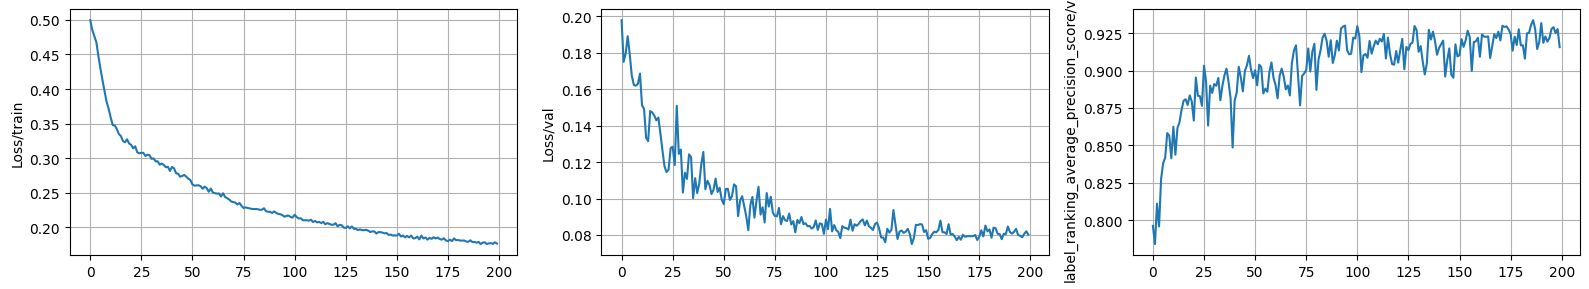

100%|██████████| 200/200 [1:53:48<00:00, 34.14s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

          alkane       0.90      0.89      0.89       826
          methyl       0.90      0.86      0.88       730
          alkene       0.86      0.45      0.59       166
          alkyne       0.80      0.20      0.32        20
        alcohols       0.91      0.57      0.70       260
          amines       0.90      0.48      0.63       158
        nitriles       1.00      0.09      0.17        55
       aromatics       0.95      0.95      0.95       674
   alkyl halides       0.84      0.39      0.53       291
          esters       0.96      0.55      0.70       139
         ketones       0.96      0.22      0.36       107
       aldehydes       1.00      0.16      0.27        32
carboxylic acids       0.82      0.36      0.50        74
           ether       0.94      0.61      0.74       300
    acyl halides       0.00      0.00      0.00         7
          amides       0.82      0.16      0.27        86
           ni

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [99]:
#Обучение и сохранение модели
train_and_save_model(IrResnet8, '50', name = 'v0.8.4.gl5n', mode = 'old')

In [ ]:
#trainer = Trainer(model= model, plotter = irpp, lr = 1e-7)
trainer(dataloader_ir_train, dataloader_ir_val, epochs = 50)


In [103]:
cr = get_statistic(model, device, dataloader_ir_test, tolerance = 0.5)
print(cr)

                  precision    recall  f1-score   support

          alkane       0.90      0.89      0.89       826
          methyl       0.90      0.86      0.88       730
          alkene       0.86      0.45      0.59       166
          alkyne       0.80      0.20      0.32        20
        alcohols       0.91      0.57      0.70       260
          amines       0.90      0.48      0.63       158
        nitriles       1.00      0.09      0.17        55
       aromatics       0.95      0.95      0.95       674
   alkyl halides       0.84      0.39      0.53       291
          esters       0.96      0.55      0.70       139
         ketones       0.96      0.22      0.36       107
       aldehydes       1.00      0.16      0.27        32
carboxylic acids       0.82      0.36      0.50        74
           ether       0.94      0.61      0.74       300
    acyl halides       0.00      0.00      0.00         7
          amides       0.82      0.16      0.27        86
           ni

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
save_model_all(model, trainer, cr, version = 'v0.8.2.gl5n'+'.'+'50')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Оценка качества модели

In [ ]:
#Очистка памяти GPU
import gc
torch.cuda.empty_cache()
gc.collect()

#Визуализация внимания

Только для версии v0.6.

In [ ]:
# model10.eval()
# data1 = []
# #Расчёт по тестовому даталоадеру предсказанных и реальных значений
# for data, label in dataloader_ir_val:
#     #print(data[0].unsqueeze(0).size())
#     data1 = data[3].unsqueeze(0)
#     out, a1, a2 = model10.to(device)(data1.to(device))
#     data1.to('cpu')
#     model10.to('cpu')
#     out.to('cpu')
#     a1.detach().to('cpu')
#     a2.detach().to('cpu')
#     break
# print(a1.size(), a2.size(), data1.size())

In [ ]:
# a11 = F.interpolate(a1.detach().to('cpu'), scale_factor=4)
# plt.plot(data1[0][0].detach().to('cpu'), a11[0][0])

In [ ]:
# a21 = F.interpolate(a2.detach().to('cpu'), scale_factor=8)
# plt.plot(data1[0][0].detach().to('cpu'), a11[0][0])

In [ ]:
# plt.plot(data1[0][0].detach().to('cpu'),data1[0][1].detach().to('cpu'))

In [ ]:
# def visualize_attention(I_train,a,up_factor,no_attention=False):
#     img = I_train.permute((1,2,0)).cpu().numpy()
#     # compute the heatmap
#     if up_factor > 1:
#         a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
#     attn = utils.make_grid(a, nrow=8, normalize=True, scale_each=True)
#     attn = attn.permute((1,2,0)).mul(255).byte().cpu().numpy()
#     attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
#     attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
#     attn = np.float32(attn) / 255
#     # add the heatmap to the image
#     img=cv2.resize(img,(466,60))
#     if no_attention:
#         return torch.from_numpy(img)
#     else:
#         vis = 0.6 * img + 0.4 * attn
#         return torch.from_numpy(vis)

# Статистика

## 14.03.2023

Базовая модель - 0: 8 сверточных слоёв (3 макспула, после каждого удвоения признаков). hidden_size = 11. Точность 0.6 на 100 эпохах (переобучение). lr = 0.001
Количество параметров: порядка 18 млн

v0.1. 8 сверточных (3 макспула, удвоение 1 после второго). hidden_size = 11. Точность 0,45 на 40 эпохах, потом переобучение до 0,6. lr = 0.0005.
Количество параметров: 5,058,328

v0.2.0 вход+ 5 слоёв по 3 базовых блока по 2 сверки = 31 hidden_size = 11.сверточный слой. Hidden_size = 11. ;r = 0.0005. Точность 0.43 20 эпохах, потом переобучение.
Количество параметров: 350,158

v0.2.0.1 вход+ 5 слоёв по 3 базовых блока по 2 сверки = 31 сверточный слой. Hidden_size = 20. lr = 0.0005. Точность 0.41 на 20 эпохах, потом переобучение.
Количество параметров: 655,357

v0.2.1 вход+ 5 слоёв по 3 базовых блока по 2 сверки = 31 сверточный слой + 2 fc + 1 do (0.5). Hidden_size = 10. lr = 0.0005. label_ranking_average_precision_score **0,875** на 25 эпохах, потом переобучение.
Количество параметров: 3,753,407

v0.2.2  вход+ 5 слоёв по 3 базовых блока по 2 сверки = 31 сверточный слой + 2 fc + 1 do (0.5) между первым и вторым fc. Hidden_size = 10. lr = 0.0005. label_ranking_average_precision_score **0,91** на 45 эпохах, потом переобучение.
Количество параметров: 3,753,407

Подобрана функция для статистики. f1 score - дает среднее в 0,78.
Применил таки дропаут.
v0.2.2  вход+ 5 слоёв по 3 базовых блока по 2 сверки = 31 сверточный слой + 2 fc + 1 do (0.5) между первым и вторым fc. Hidden_size = 10. lr = 0.0005. label_ranking_average_precision_score **0,80** на 66 эпохах, потом переобучение. Количество параметров: 3,753,407
На выходе полнота для низких классов вообще никакая. Хотя переобучение есть. Попробую снизить скорость и дропаут.

v0.2.3  вход+ 5 слоёв по 3 базовых блока по 2 сверки = 31 сверточный слой + 2 fc + 1 do (0.3) между первым и вторым fc. Hidden_size = 10. lr = 0.0003. label_ranking_average_precision_score **0,82** на 35 эпохах, потом переобучение. Количество параметров: 3,753,407
Полнота определения страдает для классов с низким содержанием.

v0.3.0 добавил  еще один дропаут и глубины.

вход+ 8 слоёв по 3 базовых блока по 2 сверки = 41 сверточный слой + 2 fc + 2 do (0.5 и 0,2) между первым и вторым fc. Hidden_size = 10. lr = 0.0003. label_ranking_average_precision_score **0.781 на 31 эпохе** , потом переобучение. Количество параметров: 3,907,127


##18.03.2023


18/03/2023
v0.3.1 убрал избыток сверток и добавил толщины.

вход+ 4 слоёв по 3 базовых блока по 2 сверки = 21 сверточный слой + 2 fc.
Hidden_size = 20.
lr = 0.0005.

label_ranking_average_precision_score **0.871 на 8 эпохе** , потом переобучение. Количество параметров: 7,788,437.
Но в этом случае реколл для малых классов отличен от нуля. f1w - 0.76.
Добавим дропауты

v0.3.2 добавил дроп после flatten. Переобучение значительно снизилось. Не хватило 40 эпох. Высокий пресижон, но слабый рекол.Общий f1 0,5

вход+ 4 слоёв по 3 базовых блока по 2 сверки = 21 сверточный слой + 2 fc+1дроп.
Hidden_size = 20.
lr = 0.0005.  
label_ranking_average_precision_score ** 0.803 на 39 эпохе**

v0.3.3 увеличим толщину еще. вход+ 4 слоёв по 3 базовых блока по 2 сверки = 21 сверточный слой + 2 fc+1дроп.
Hidden_size = 30. (Параметров 12,114,647)
lr = 0.0005.  
label_ranking_average_precision_score **0.812 на 36 эпохе**


           precision    recall  f1-score   support
           alkane       0.97      0.51      0.67       812
           methyl       0.93      0.54      0.68       715
           alkene       1.00      0.10      0.19       165
           alkyne       1.00      0.16      0.27        19
         alcohols       0.94      0.18      0.31       271
           amines       1.00      0.07      0.13       159
         nitriles       1.00      0.02      0.04        46
        aromatics       0.98      0.75      0.85       681
    alkyl halides       0.92      0.14      0.24       317
           esters       0.97      0.43      0.60       129
          ketones       1.00      0.06      0.12       112
        aldehydes       1.00      0.39      0.56        23
    carboxylic acids    1.00      0.15      0.26        66
           ether        0.95      0.53      0.68       288
    acyl halides        0.50      0.07      0.12        14
          amides        0.60      0.03      0.06        96
           nitro        0.92      0.49      0.64        71

       micro avg        0.96      0.43      0.59      3984
       macro avg        0.92      0.27      0.38      3984
    weighted avg        0.95      0.43      0.55      3984
     samples avg        0.75      0.44      0.53      3984


v0.3.5 Повысим толщину еще. hidden_size = 50 (21,634,667 параметров). Модель не учится. А при расчёте статистики - еще и забивается память.

## 20.03.2023

20.03.2023
Добавлен взвешенный даталоадер на трейн.

v0.3.6. 8 уровней по 3 базовых блока. Уже на 40 эпохах с lr = 0.001 выходит на плато. Потом уменьшение lr = 0.0005 и lr = 0.0001 приводит к улучшению результата максимум до label_ranking_average_precision_score 0.8 на 60 эпохе.
Но статистика говорит, что слабые классы всё равно не попадают под обучение.


                 precision    recall  f1-score   support

          alkane       0.94      0.64      0.76       818
          methyl       0.92      0.46      0.61       736
          alkene       0.90      0.17      0.29       159
          alkyne       0.00      0.00      0.00        21
        alcohols       0.89      0.14      0.25       270
          amines       0.83      0.16      0.26       153
        nitriles       0.00      0.00      0.00        34
       aromatics       0.99      0.82      0.90       712
    alkyl_halides      0.95      0.23      0.37       330
          esters       1.00      0.45      0.62       128
         ketones       0.91      0.18      0.31       109
       aldehydes       0.00      0.00      0.00        17
    carboxylic_acids   0.90      0.11      0.20        81
           ether       0.96      0.43      0.60       274
    acyl halides       1.00      0.17      0.29        12
          amides       1.00      0.08      0.15        74
           nitro       0.95      0.50      0.65        72

       micro avg       0.95      0.47      0.62      4000
       macro avg       0.77      0.27      0.37      4000
    weighted avg       0.92      0.47      0.59      4000
     samples avg       0.84      0.48      0.58      4000


v0.3.6.  4 уровней по 3 базовых блока.
label_ranking_average_precision_score  = 0.797 на 76 эпохе

                 precision    recall  f1-score   support

          alkane       0.99      0.48      0.64       818
          methyl       0.99      0.38      0.54       736
          alkene       0.00      0.00      0.00       159
          alkyne       1.00      0.24      0.38        21
        alcohols       1.00      0.12      0.22       270
          amines       0.00      0.00      0.00       153
        nitriles       0.00      0.00      0.00        34
       aromatics       0.99      0.44      0.61       712
    alkyl halides      1.00      0.00      0.01       330
          esters       0.00      0.00      0.00       128
         ketones       0.00      0.00      0.00       109
       aldehydes       0.50      0.06      0.11        17
    carboxylic acids   0.00      0.00      0.00        81
           ether       1.00      0.04      0.08       274
    acyl halides       0.00      0.00      0.00        12
          amides       1.00      0.01      0.03        74
           nitro       0.00      0.00      0.00        72

       micro avg       0.99      0.26      0.41      4000
       macro avg       0.50      0.10      0.15      4000
    weighted avg       0.81      0.26      0.36      4000
     samples avg       0.59      0.28      0.36      4000

Высокие точности для больших классов, никакие для слабых.

v0.3.7 Прикрутил AdaptiveMaxPool1d и планировщик (StepLR шаг 30 спектров, гамма = 0,2). label_ranking_average_precision_score = 0.83 на 73 эпохе
Статистика с толерантностью 0,9:

                  precision    recall  f1-score   support

          alkane       0.99      0.45      0.62       818
          methyl       0.96      0.26      0.41       736
          alkene       1.00      0.04      0.07       159
          alkyne       1.00      0.05      0.09        21
        alcohols       1.00      0.03      0.06       270
          amines       1.00      0.05      0.10       153
        nitriles       1.00      0.03      0.06        34
       aromatics       1.00      0.70      0.82       712
     alkyl halides     1.00      0.08      0.15       330
          esters       1.00      0.20      0.33       128
         ketones       1.00      0.04      0.07       109
       aldehydes       0.00      0.00      0.00        17
    carboxylic acids   1.00      0.05      0.09        81
           ether       1.00      0.26      0.41       274
    acyl halides       0.00      0.00      0.00        12
          amides       1.00      0.01      0.03        74
           nitro       1.00      0.32      0.48        72

       micro avg       0.99      0.31      0.47      4000
       macro avg       0.88      0.15      0.22      4000
    weighted avg       0.98      0.31      0.42      4000
     samples avg       0.71      0.32      0.42      4000

Статистика с толернатностью 0,7 - ф1 - 0,66

                  precision    recall  f1-score   support

          alkane       0.91      0.78      0.84       818
          methyl       0.89      0.69      0.78       736
          alkene       0.84      0.20      0.32       159
          alkyne       1.00      0.24      0.38        21
        alcohols       0.85      0.15      0.26       270
          amines       0.91      0.20      0.32       153
        nitriles       1.00      0.15      0.26        34
       aromatics       0.98      0.90      0.93       712
     alkyl halides     0.93      0.26      0.41       330
          esters       0.96      0.40      0.56       128
         ketones       0.92      0.21      0.34       109
       aldehydes       1.00      0.06      0.11        17
    carboxylic acids   0.94      0.19      0.31        81
           ether       0.95      0.50      0.65       274
    acyl halides       0.00      0.00      0.00        12
          amides       0.89      0.11      0.19        74
           nitro       0.97      0.51      0.67        72

       micro avg       0.93      0.56      0.70      4000
       macro avg       0.88      0.33      0.43      4000
    weighted avg       0.92      0.56      0.66      4000
     samples avg       0.88      0.58      0.67      4000


v0.3.8 hidden_size = 15 (5 млн параметров), 8 слоёв. два дропаута.
точность 0.825 на 170 эпохе.
Статистика на 0,7:

                precision    recall  f1-score   support

          alkane       0.94      0.79      0.86       818
          methyl       0.94      0.69      0.80       736
          alkene       1.00      0.08      0.14       159
          alkyne       0.00      0.00      0.00        21
        alcohols       0.94      0.35      0.51       270
          amines       0.97      0.20      0.34       153
        nitriles       0.00      0.00      0.00        34
       aromatics       0.96      0.89      0.92       712
     alkyl halides     0.97      0.09      0.17       330
          esters       0.94      0.12      0.22       128
         ketones       1.00      0.03      0.05       109
       aldehydes       0.00      0.00      0.00        17
    carboxylic acids   0.75      0.04      0.07        81
           ether       1.00      0.28      0.44       274
    acyl halides       0.00      0.00      0.00        12
          amides       0.50      0.01      0.03        74
           nitro       1.00      0.14      0.24        72

       micro avg       0.95      0.52      0.67      4000
       macro avg       0.70      0.22      0.28      4000
    weighted avg       0.92      0.52      0.60      4000
     samples avg       0.90      0.54      0.64      4000

Везде наблюдаются высокие precision и низкие recall, за исключением самых крупных классов. Самые редкие классы по нулям.
Требуется научиться аугментации спектров, повысить количество малых классов, хотя бы раз в 10-100.

Планы:

*   Заняться аугментацией спектров
*   Самые редкие классы выделить и аугментировать многократно.
*   Используя имеющуюся модель научиться определять полосы частых классов и аугментировать спектры, вырежая эти диапазоны.
*   Научиться работать со спектрами других размеров.






## 21.03.2023

v0.3.9 4 уровня скрытый уровень 10 Прикручена BCELosswithlogits убран слой с сигмоидом. Убран рандомный семплер. Веса в лосс обратные.

                  precision    recall  f1-score   support

          alkane       0.70      1.00      0.82       831
          methyl       0.63      1.00      0.77       750
          alkene       0.00      0.00      0.00       151
          alkyne       0.00      0.00      0.00        22
        alcohols       0.00      0.00      0.00       253
          amines       0.00      0.00      0.00       148
        nitriles       0.00      0.00      0.00        45
       aromatics       0.60      1.00      0.75       712
    alkyl halides      0.00      0.00      0.00       316
          esters       0.00      0.00      0.00       148
         ketones       0.00      0.00      0.00       105
       aldehydes       0.00      0.00      0.00        23
    carboxylic acids   0.00      0.00      0.00        84
           ether       0.00      0.00      0.00       311
    acyl halides       0.00      0.00      0.00        17
          amides       0.00      0.00      0.00        70
           nitro       0.00      0.00      0.00        63

       micro avg       0.64      0.57      0.60      4049
       macro avg       0.11      0.18      0.14      4049
    weighted avg       0.37      0.57      0.44      4049
     samples avg       0.64      0.60      0.60      4049


Обучение только на большие классы.

v0.3.10 BCELosswithlogits Веса в лосс прямые. 0.777 на 76 эпохе. Статистика на толерантности 0,8

                  precision    recall  f1-score   support

          alkane       0.94      0.76      0.84       831
          methyl       0.92      0.64      0.75       750
          alkene       0.94      0.11      0.19       151
          alkyne       0.00      0.00      0.00        22
        alcohols       0.98      0.17      0.30       253
          amines       1.00      0.01      0.03       148
        nitriles       0.00      0.00      0.00        45
       aromatics       0.97      0.90      0.93       712
    alkyl halides      1.00      0.15      0.26       316
          esters       0.97      0.38      0.54       148
         ketones       1.00      0.06      0.11       105
       aldehydes       0.00      0.00      0.00        23
    carboxylic acids   0.80      0.05      0.09        84
           ether       0.97      0.44      0.61       311
    acyl halides       0.00      0.00      0.00        17
          amides       0.00      0.00      0.00        70
           nitro       1.00      0.29      0.44        63

       micro avg       0.95      0.51      0.67      4049
       macro avg       0.68      0.23      0.30      4049
    weighted avg       0.91      0.51      0.60      4049
     samples avg       0.89      0.53      0.64      4049


Статистика с толерантностью 0,5

                 precision    recall  f1-score   support

          alkane       0.92      0.81      0.86       831
          methyl       0.89      0.72      0.79       750
          alkene       0.90      0.13      0.22       151
          alkyne       0.00      0.00      0.00        22
        alcohols       0.96      0.21      0.34       253
          amines       1.00      0.06      0.11       148
        nitriles       1.00      0.02      0.04        45
       aromatics       0.97      0.93      0.95       712
     alkyl halides     1.00      0.21      0.35       316
          esters       0.97      0.46      0.62       148
         ketones       1.00      0.10      0.19       105
       aldehydes       0.00      0.00      0.00        23
    carboxylic acids   0.80      0.05      0.09        84
           ether       0.96      0.53      0.68       311
    acyl halides       0.00      0.00      0.00        17
          amides       0.00      0.00      0.00        70
           nitro       1.00      0.37      0.53        63

       micro avg       0.94      0.57      0.71      4049
       macro avg       0.73      0.27      0.34      4049
    weighted avg       0.91      0.57      0.64      4049
     samples avg       0.89      0.58      0.68      4049

v0.3.11 Рандомный даталоадер вернут. **0.904** на 116 эпохе
Статистика на 0,5:

                  precision    recall  f1-score   support

          alkane       0.94      0.86      0.90       829
          methyl       0.92      0.81      0.86       767
          alkene       1.00      0.09      0.17       164
          alkyne       1.00      0.06      0.11        17
        alcohols       0.97      0.28      0.44       277
          amines       0.93      0.18      0.30       145
        nitriles       0.00      0.00      0.00        45
       aromatics       0.97      0.89      0.93       688
     alkyl halides     0.97      0.14      0.24       279
          esters       1.00      0.29      0.45       150
         ketones       0.00      0.00      0.00       107
       aldehydes       0.00      0.00      0.00        23
    carboxylic acids   0.91      0.13      0.23        75
           ether       0.99      0.41      0.58       312
    acyl halides       0.00      0.00      0.00        11
          amides       0.00      0.00      0.00        84
           nitro       0.93      0.21      0.34        62

       micro avg       0.95      0.57      0.71      4035
       macro avg       0.68      0.26      0.33      4035
    weighted avg       0.89      0.57      0.64      4035
     samples avg       0.91      0.59      0.69      4035


Начинает получаться с малыми классами. Появился реколл для классов 45-80 шт.
Надо увеличить еще веса для самых малых классов.

v0.3.12 Уменьшение весов малых классов еще сильнее.

                  precision    recall  f1-score   support

          alkane       0.94      0.78      0.85       829
          methyl       0.95      0.71      0.81       767
          alkene       0.00      0.00      0.00       164
          alkyne       0.00      0.00      0.00        17
        alcohols       0.00      0.00      0.00       277
          amines       0.00      0.00      0.00       145
        nitriles       0.00      0.00      0.00        45
       aromatics       0.94      0.77      0.85       688
    alkyl halides      0.00      0.00      0.00       279
          esters       0.00      0.00      0.00       150
         ketones       0.00      0.00      0.00       107
       aldehydes       0.00      0.00      0.00        23
    carboxylic acids   0.00      0.00      0.00        75
           ether       1.00      0.06      0.12       312
    acyl halides       0.00      0.00      0.00        11
          amides       0.00      0.00      0.00        84
           nitro       0.00      0.00      0.00        62

       micro avg       0.94      0.43      0.59      4035
       macro avg       0.23      0.14      0.16      4035
    weighted avg       0.61      0.43      0.48      4035
     samples avg       0.87      0.47      0.58      4035

Не помогло. Увеличиваем веса. Но не сработало:

                  precision    recall  f1-score   support

          alkane       0.00      0.00      0.00       835
          methyl       0.00      0.00      0.00       742
          alkene       0.00      0.00      0.00       168
          alkyne       0.00      0.00      0.00        27
        alcohols       0.00      0.00      0.00       258
          amines       0.00      0.00      0.00       152
        nitriles       0.00      0.00      0.00        44
       aromatics       0.00      0.00      0.00       668
     alkyl halides     0.00      0.00      0.00       292
          esters       0.00      0.00      0.00       134
         ketones       0.00      0.00      0.00       120
       aldehydes       0.00      0.00      0.00        25
    carboxylic acids   0.00      0.00      0.00        63
           ether       0.00      0.00      0.00       283
    acyl halides       0.00      0.00      0.00        11
          amides       0.00      0.00      0.00        75
           nitro       0.00      0.00      0.00        52

       micro avg       0.00      0.00      0.00      3949
       macro avg       0.00      0.00      0.00      3949
    weighted avg       0.00      0.00      0.00      3949
     samples avg       0.00      0.00      0.00      3949

## 22.03.2023

Подкрутка весов немного помогла. Но мелкие классы всё еще плохо читаются:

                precision    recall  f1-score   support

          alkane       0.90      0.84      0.87       835
          methyl       0.88      0.72      0.79       742
          alkene       0.96      0.14      0.24       168
          alkyne       0.00      0.00      0.00        27
        alcohols       0.85      0.18      0.30       258
          amines       0.92      0.07      0.13       152
        nitriles       0.00      0.00      0.00        44
       aromatics       0.96      0.90      0.93       668
     alkyl halides     0.91      0.28      0.43       292
          esters       0.94      0.46      0.61       134
         ketones       1.00      0.09      0.17       120
       aldehydes       0.00      0.00      0.00        25
    carboxylic acids   0.83      0.08      0.14        63
           ether       0.93      0.61      0.74       283
    acyl halides       0.00      0.00      0.00        11
          amides       0.83      0.07      0.12        75
           nitro       0.93      0.54      0.68        52

       micro avg       0.91      0.58      0.71      3949
       macro avg       0.70      0.29      0.36      3949
    weighted avg       0.89      0.58      0.65      3949
     samples avg       0.89      0.59      0.68      3949

Уменьшили веса для малых классов еще в 2 раза. Похоже не хватает времени доучить.

                  precision    recall  f1-score   support

          alkane       0.90      0.80      0.85       835
          methyl       0.90      0.65      0.76       742
          alkene       1.00      0.04      0.08       168
          alkyne       0.00      0.00      0.00        27
        alcohols       0.88      0.03      0.05       258
          amines       1.00      0.01      0.01       152
        nitriles       0.00      0.00      0.00        44
       aromatics       0.96      0.88      0.91       668
    alkyl halides      0.95      0.07      0.13       292
          esters       0.97      0.27      0.42       134
         ketones       1.00      0.03      0.05       120
       aldehydes       0.00      0.00      0.00        25
    carboxylic acids   0.00      0.00      0.00        63
           ether       0.99      0.37      0.54       283
    acyl halides       0.00      0.00      0.00        11
          amides       0.00      0.00      0.00        75
           nitro       1.00      0.12      0.21        52

       micro avg       0.92      0.49      0.64      3949
       macro avg       0.62      0.19      0.24      3949
    weighted avg       0.88      0.49      0.55      3949
     samples avg       0.88      0.51      0.62      3949

v0.4.0. добавлены макспулы между слоями и общее количество параметров снижено до 0,5 млн.

                 precision    recall  f1-score   support

          alkane       0.93      0.58      0.72       835
          methyl       0.88      0.44      0.59       742
          alkene       0.95      0.11      0.19       168
          alkyne       0.00      0.00      0.00        27
        alcohols       0.91      0.12      0.21       258
          amines       0.84      0.11      0.19       152
        nitriles       0.00      0.00      0.00        44
       aromatics       0.84      0.96      0.89       668
    alkyl halides      0.78      0.46      0.58       292
          esters       0.98      0.35      0.52       134
         ketones       0.92      0.09      0.17       120
       aldehydes       0.00      0.00      0.00        25
    carboxylic acids   0.00      0.00      0.00        63
           ether       0.96      0.45      0.61       283
    acyl halides       0.00      0.00      0.00        11
          amides       0.00      0.00      0.00        75
           nitro       0.94      0.33      0.49        52

       micro avg       0.88      0.47      0.61      3949
       macro avg       0.58      0.23      0.30      3949
    weighted avg       0.84      0.47      0.56      3949
     samples avg       0.79      0.48      0.57      3949

Обучается также, такая же скорость, но малые классы также не берет, даже при доучивании.

## 28.03.2023

v0.4.2.50-60. Убран адаптивный макс пул. Последние цифры hidden -size

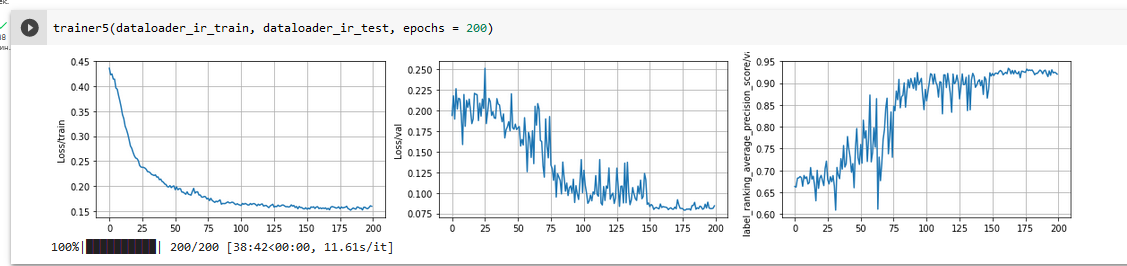

v0.4.2.20.raw - c адаптивным макс пулом обучена на неподготовленных данных.

v0.4.3.30 - обучение только на y

## 04.04.2023

v0.5.1.50 убрал два макс-пула. Количество параметров - 8 млн.
По идее на начальных этапах двойное уменьшение размера ведёт к потери малых значений - что плохо для малых классов.

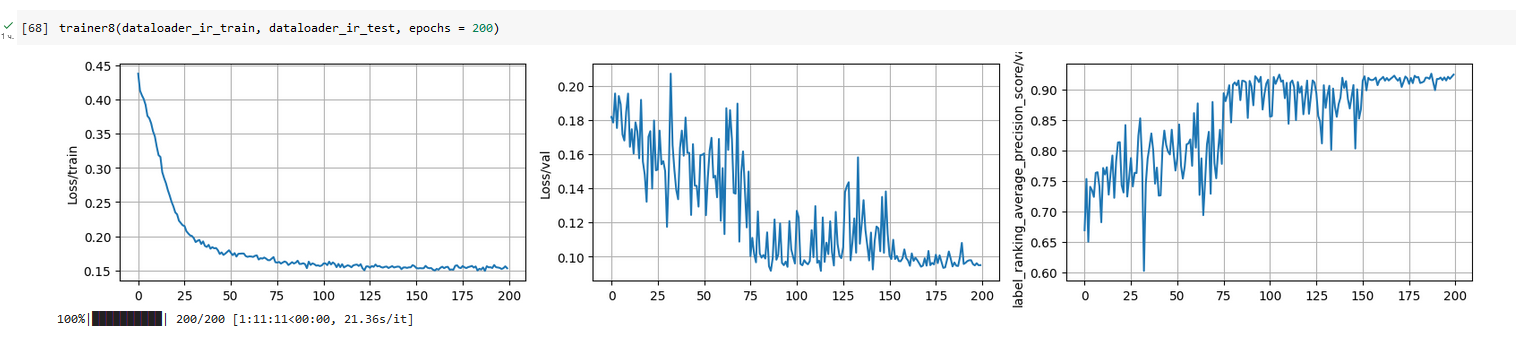

weighted f1 0.77

##02.06.2023
Добавлена версия v0.6.0. В версии убран один слой дропаутов. Добавлено два слоя внимания.
                  precision    recall  f1-score   support

          alkane       0.88      0.84      0.86       802
          methyl       0.84      0.77      0.80       725
          alkene       0.74      0.31      0.44       175
          alkyne       1.00      0.21      0.35        14
        alcohols       0.82      0.70      0.75       279
          amines       0.80      0.45      0.57       154
        nitriles       0.00      0.00      0.00        43
       aromatics       0.92      0.91      0.92       686
    alkyl halides      0.65      0.46      0.54       302
          esters       0.91      0.59      0.72       116
         ketones       0.83      0.26      0.39       112
       aldehydes       1.00      0.33      0.50        24
    carboxylic acids   0.88      0.26      0.40        82
           ether       0.85      0.49      0.62       280
    acyl halides       0.00      0.00      0.00         9
          amides       0.71      0.11      0.19        91
           nitro       0.88      0.31      0.46        70

       micro avg       0.85      0.66      0.74      3964
       macro avg       0.75      0.41      0.50      3964
    weighted avg       0.83      0.66      0.72      3964
     samples avg       0.85      0.67      0.72      3964

##03.06.2023

v0.6.0.10. Тестирование сети со скрытым слоем 10 и 20.

Обучение 10:

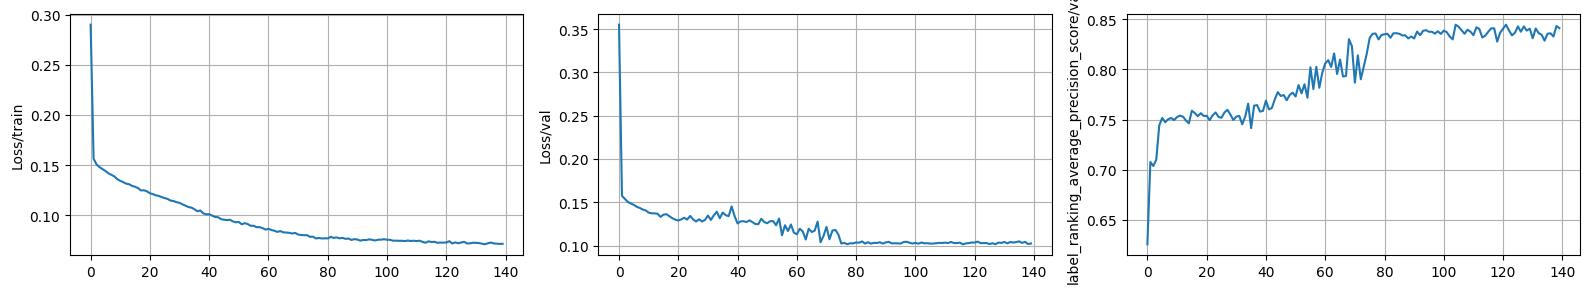

Обучение 20:

![изображение.png](
)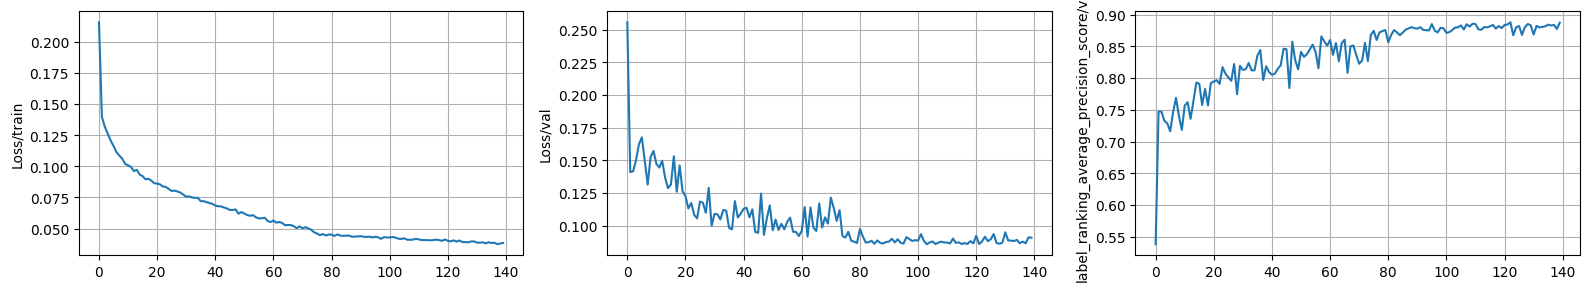

Сравнение статистик:

                  precision    recall  f1-score   support

          alkane       0.88      0.78      0.83       802
          methyl       0.89      0.69      0.78       725
          alkene       1.00      0.10      0.19       175
          alkyne       0.00      0.00      0.00        14
        alcohols       0.94      0.32      0.47       279
          amines       1.00      0.01      0.01       154
        nitriles       0.00      0.00      0.00        43
       aromatics       0.93      0.85      0.89       686
      alkyl halides    0.69      0.04      0.07       302
          esters       1.00      0.11      0.20       116
         ketones       0.00      0.00      0.00       112
       aldehydes       0.00      0.00      0.00        24
    carboxylic acids   0.00      0.00      0.00        82
           ether       0.94      0.21      0.34       280
    acyl halides       0.00      0.00      0.00         9
          amides       0.00      0.00      0.00        91
           nitro       0.00      0.00      0.00        70

       micro avg       0.90      0.48      0.63      3964
       macro avg       0.49      0.18      0.22      3964
    weighted avg       0.80      0.48      0.54      3964
     samples avg       0.86      0.50      0.61      3964

                  precision    recall  f1-score   support

          alkane       0.90      0.83      0.86       802
          methyl       0.87      0.79      0.83       725
          alkene       0.91      0.24      0.38       175
          alkyne       0.00      0.00      0.00        14
        alcohols       0.92      0.44      0.60       279
          amines       0.84      0.10      0.18       154
        nitriles       0.00      0.00      0.00        43
       aromatics       0.95      0.87      0.91       686
      alkyl halides    0.87      0.15      0.25       302
          esters       1.00      0.34      0.50       116
         ketones       0.80      0.04      0.07       112
       aldehydes       0.00      0.00      0.00        24
    carboxylic acids   0.67      0.02      0.05        82
           ether       0.94      0.35      0.51       280
    acyl halides       0.00      0.00      0.00         9
          amides       1.00      0.01      0.02        91
           nitro       0.00      0.00      0.00        70

       micro avg       0.91      0.55      0.69      3964
       macro avg       0.63      0.25      0.30      3964
    weighted avg       0.86      0.55      0.62      3964
     samples avg       0.87      0.57      0.66      3964

F1 повышается с 0.54 до 0.62

##v0.6.1 Добавлен второй дропаут.

##v0.7

v0.7.0 Добавлены 72 слоя мааксимумов для каждой полосы колебания
v0.7.1 72 слоя максимумов для каждой полосы колебания схлопнуты в один


## Тест аугментаций
v0.5.2.0 - без weightet sampler'а. Без аугментаций



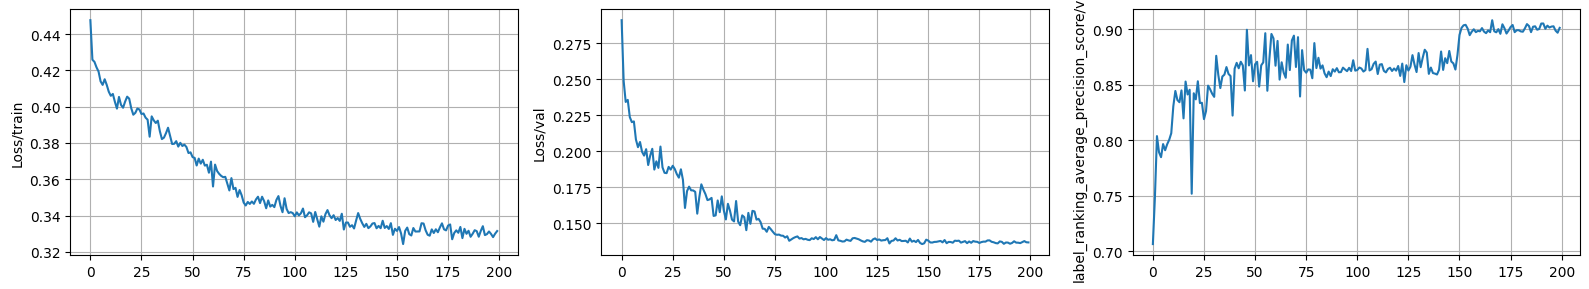

weighted avg       0.85      0.45      0.53

v0.5.2.g - без weightet sampler'а. Гауссовый шум 10-5.

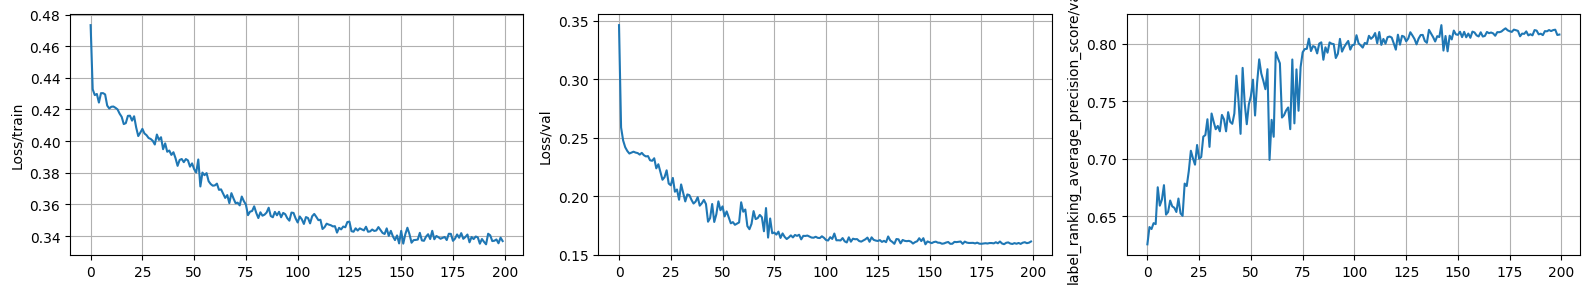

weighted avg       0.78      0.42      0.51

v0.5.2.n - без weightet sampler'а. Нормализация на трейновый датасет. Не учится.

v0.5.2.l - без weightet sampler'а. Добавление линейной функции с наклоном 10-5*рандом.

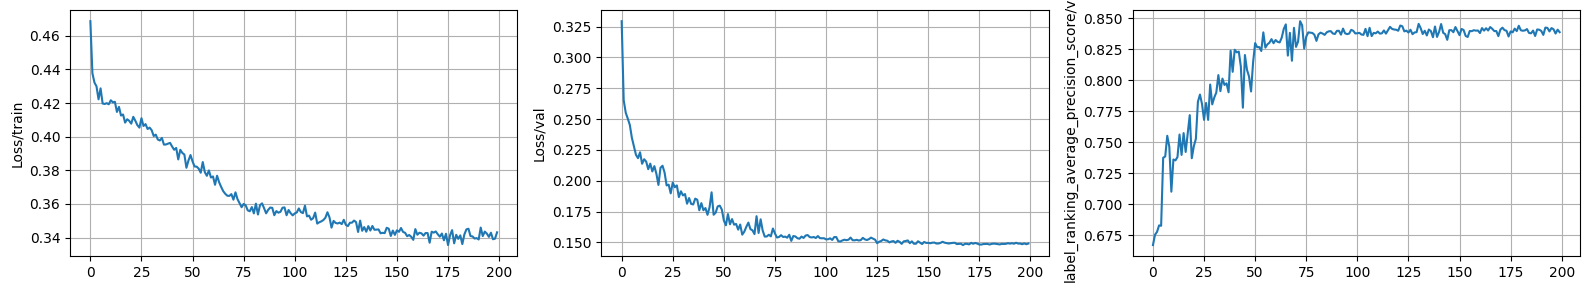

 weighted avg       0.76      0.43      0.50

v0.5.2.g6 - без weightet sampler'а. Гауссовый шум 10-6.

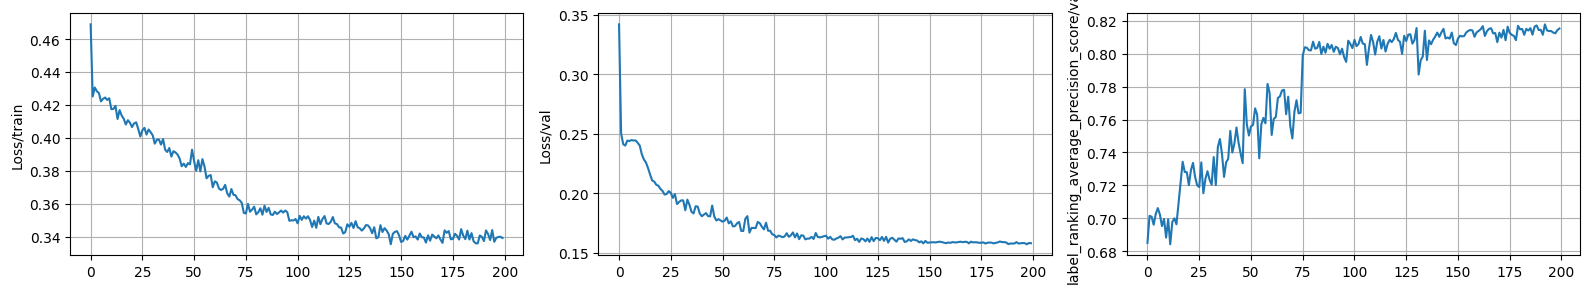

 weighted avg       0.70      0.39      0.47

v0.5.2.g7 Гауссовый шум 10-7

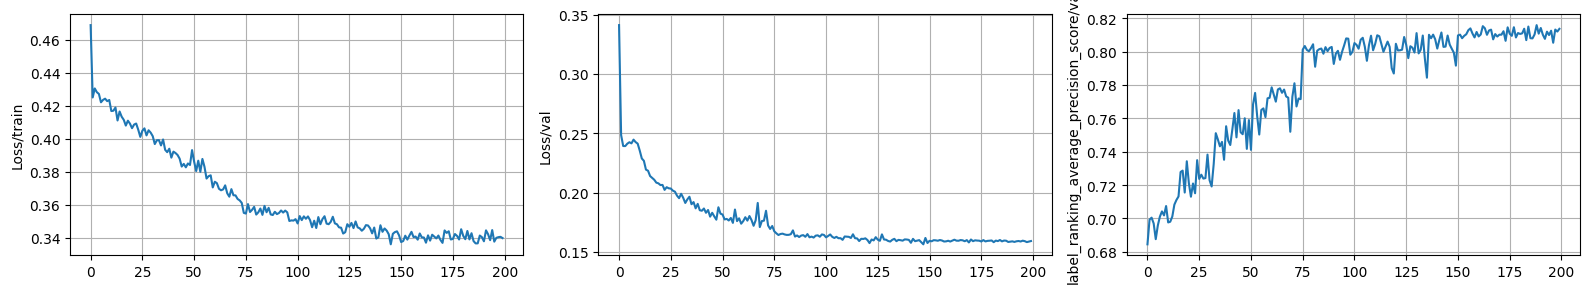

 weighted avg       0.66      0.39      0.46

## Аугментация датасета 0.25 и 0.3

v0.5.3.g4 - добавление гауссового шума 10-5 и линейного 10-5 для 10 и 50.

Hidden size = 10

                  precision    recall  f1-score   support

          alkane       0.96      0.67      0.79      1003
          methyl       0.96      0.47      0.63       770
          alkene       0.00      0.00      0.00       267
          alkyne       0.00      0.00      0.00        25
        alcohols       0.96      0.19      0.32       380
          amines       1.00      0.01      0.02       279
        nitriles       0.00      0.00      0.00        88
       aromatics       0.98      0.79      0.88      1076
    alkyl halides      1.00      0.02      0.04       543
          esters       0.00      0.00      0.00       128
         ketones       0.00      0.00      0.00       146
       aldehydes       0.00      0.00      0.00        49
    carboxylic acids   0.00      0.00      0.00       114
           ether       1.00      0.00      0.01       300
    acyl halides       0.00      0.00      0.00        26
          amides       0.00      0.00      0.00       145
           nitro       0.00      0.00      0.00       126

       micro avg       0.97      0.36      0.53      5465
       macro avg       0.40      0.13      0.16      5465
    weighted avg       0.77      0.36      0.43      5465
     samples avg       0.80      0.39      0.50      5465

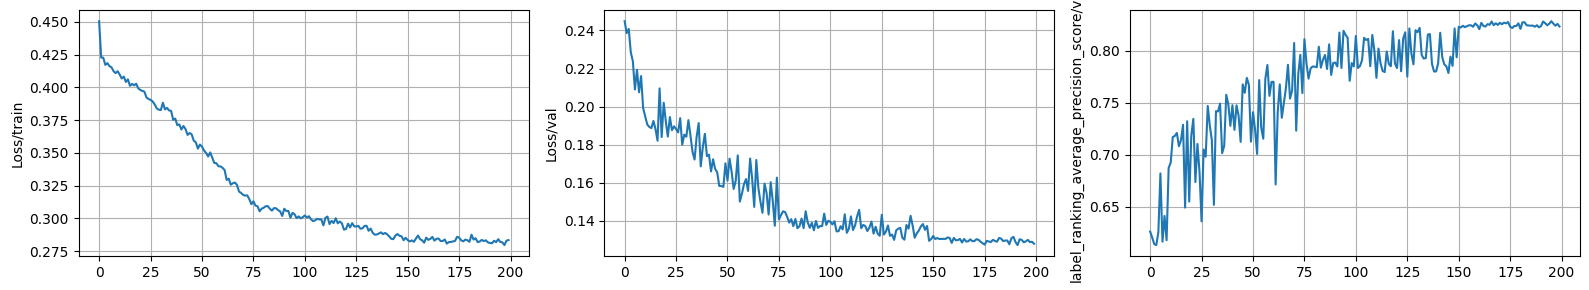

Hidden size = 50

                  precision    recall  f1-score   support

          alkane       0.96      0.83      0.89      1003
          methyl       0.95      0.76      0.85       770
          alkene       0.99      0.36      0.52       267
          alkyne       0.00      0.00      0.00        25
        alcohols       0.97      0.48      0.65       380
          amines       0.95      0.41      0.57       279
        nitriles       0.00      0.00      0.00        88
       aromatics       0.98      0.96      0.97      1076
    alkyl halides      0.96      0.60      0.74       543
          esters       0.98      0.41      0.57       128
         ketones       1.00      0.09      0.16       146
       aldehydes       1.00      0.10      0.19        49
    carboxylic acids   1.00      0.17      0.29       114
           ether       0.97      0.49      0.65       300
    acyl halides       0.00      0.00      0.00        26
          amides       1.00      0.09      0.16       145
           nitro       1.00      0.31      0.47       126

       micro avg       0.97      0.63      0.77      5465
       macro avg       0.81      0.36      0.45      5465
    weighted avg       0.95      0.63      0.72      5465
     samples avg       0.95      0.67      0.76      5465

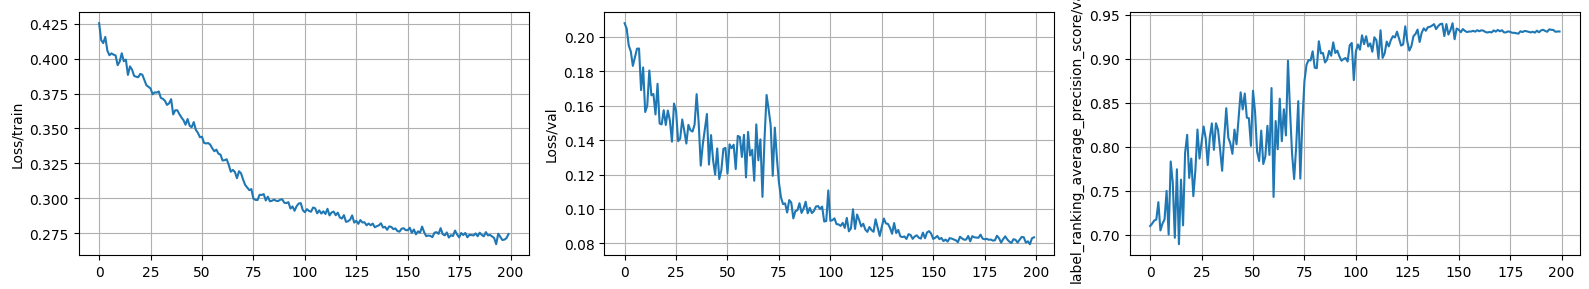

##20.07.2023


Аугментация только части датасета - трейна. Возвращён взвешенный Sampler.

v0.5.4.gl5 - WtdRandomSampler по нормированным редкостям + аугментация train гауссом и линейным 10-5.

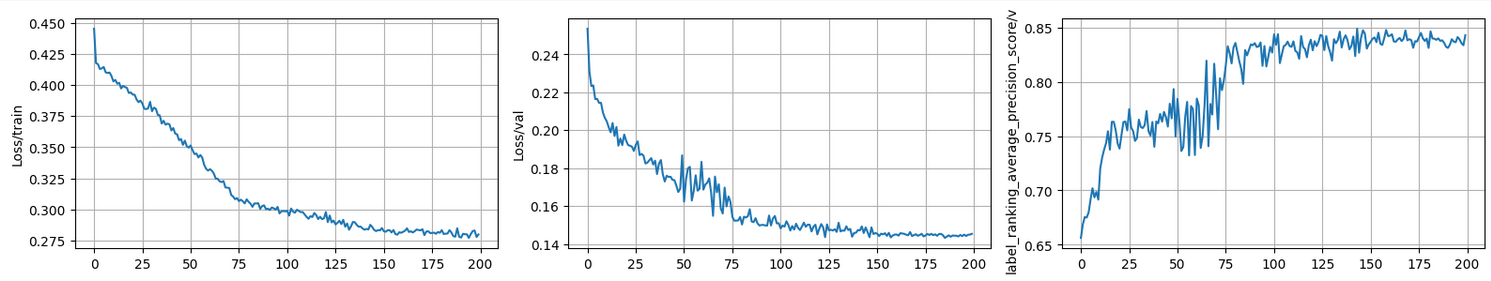

                precision    recall  f1-score   support

          alkane       0.95      0.65      0.77      1622
          methyl       0.96      0.47      0.63      1480
          alkene       1.00      0.01      0.02       320
          alkyne       0.00      0.00      0.00        48
        alcohols       0.94      0.16      0.28       545
          amines       0.00      0.00      0.00       320
        nitriles       0.00      0.00      0.00        95
       aromatics       0.96      0.81      0.88      1378
     alkyl halides     0.97      0.05      0.09       604
          esters       1.00      0.01      0.01       270
         ketones       0.00      0.00      0.00       216
       aldehydes       0.00      0.00      0.00        51
    carboxylic acids   0.00      0.00      0.00       142
           ether       0.98      0.10      0.18       591
    acyl halides       0.00      0.00      0.00        26
          amides       0.00      0.00      0.00       171
           nitro       0.00      0.00      0.00       140

       micro avg       0.95      0.38      0.54      8019
       macro avg       0.46      0.13      0.17      8019
    weighted avg       0.82      0.38      0.46      8019
     samples avg       0.85      0.41      0.52      8019

v0.5.5.gl5 - WtdRandomSampler по вероятностям + аугментация train гауссом и линейным 10-5. hs = 10

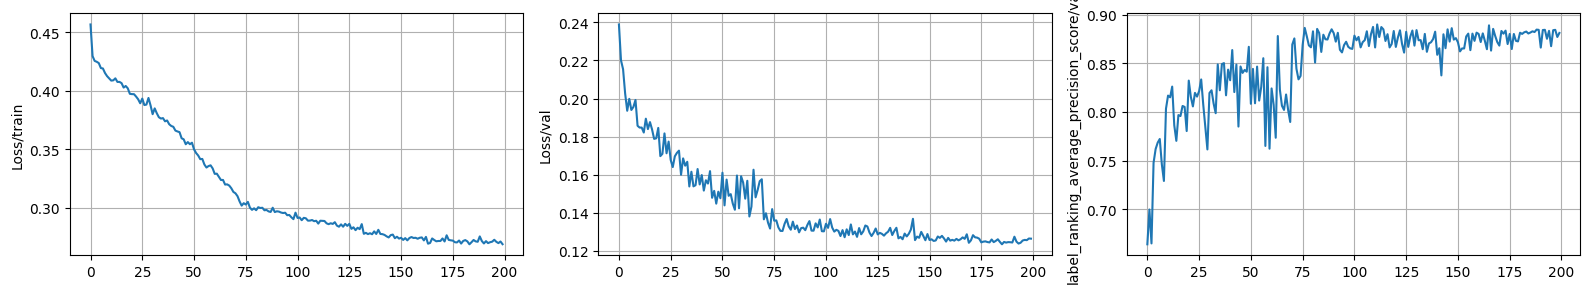

               precision    recall  f1-score   support

          alkane       0.95      0.66      0.78      1622
          methyl       0.94      0.52      0.67      1480
          alkene       1.00      0.07      0.12       320
          alkyne       0.00      0.00      0.00        48
        alcohols       0.93      0.24      0.38       545
          amines       0.96      0.07      0.13       320
        nitriles       0.00      0.00      0.00        95
       aromatics       0.95      0.80      0.87      1378
    alkyl halides      0.91      0.07      0.13       604
          esters       0.00      0.00      0.00       270
         ketones       0.00      0.00      0.00       216
       aldehydes       0.00      0.00      0.00        51
    carboxylic acids   0.00      0.00      0.00       142
           ether       1.00      0.08      0.15       591
    acyl halides       0.00      0.00      0.00        26
          amides       0.00      0.00      0.00       171
           nitro       0.00      0.00      0.00       140

       micro avg       0.95      0.40      0.56      8019
       macro avg       0.45      0.15      0.19      8019
    weighted avg       0.81      0.40      0.49      8019
     samples avg       0.86      0.43      0.55      8019

v0.5.5.gl5 - WtdRandomSampler по вероятностям + аугментация train гауссом и линейным 10-5. hs = 50

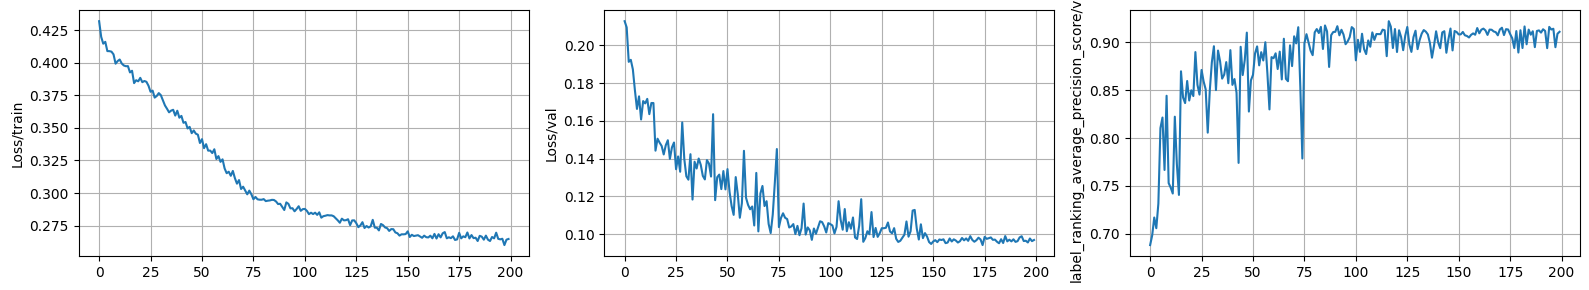

                 precision    recall  f1-score   support

          alkane       0.91      0.83      0.87      1622
          methyl       0.90      0.78      0.83      1480
          alkene       0.83      0.31      0.45       320
          alkyne       1.00      0.21      0.34        48
        alcohols       0.89      0.59      0.71       545
          amines       0.88      0.35      0.50       320
        nitriles       0.78      0.07      0.13        95
       aromatics       0.95      0.91      0.93      1378
     alkyl halides     0.77      0.44      0.56       604
          esters       0.94      0.54      0.68       270
         ketones       0.90      0.26      0.40       216
       aldehydes       0.93      0.25      0.40        51
    carboxylic acids   0.91      0.34      0.49       142
           ether       0.93      0.56      0.70       591
    acyl halides       0.00      0.00      0.00        26
          amides       0.79      0.13      0.23       171
           nitro       0.98      0.38      0.55       140

       micro avg       0.91      0.65      0.76      8019
       macro avg       0.84      0.41      0.52      8019
    weighted avg       0.90      0.65      0.73      8019
     samples avg       0.89      0.67      0.73      8019

## 21.07.2023

v0.5.6.gl5 - модель 5 с нормировкой спектров на нормальное распределение и аугментацией 30% датасета.

hs = 10 показало лучшие результаты среди 10ток. Почти 91 для pres и 0.4 recall f1 = 0.61. Но при этом обучается почти на все классы, а не только на огромные.


                  precision    recall  f1-score   support

          alkane       0.96      0.73      0.83      1622
          methyl       0.95      0.56      0.71      1480
          alkene       0.96      0.16      0.28       320
          alkyne       1.00      0.04      0.08        48
        alcohols       0.96      0.40      0.57       545
          amines       1.00      0.19      0.32       320
        nitriles       1.00      0.05      0.10        95
       aromatics       0.98      0.90      0.94      1378
    alkyl halides      0.95      0.26      0.41       604
          esters       1.00      0.11      0.19       270
         ketones       1.00      0.00      0.01       216
       aldehydes       1.00      0.02      0.04        51
    carboxylic acids   0.82      0.06      0.12       142
           ether       0.97      0.37      0.53       591
    acyl halides       0.00      0.00      0.00        26
          amides       0.00      0.00      0.00       171
           nitro       1.00      0.12      0.22       140

       micro avg       0.97      0.50      0.66      8019
       macro avg       0.86      0.23      0.31      8019
    weighted avg       0.94      0.50      0.61      8019
     samples avg       0.91      0.53      0.64      8019


hs = 20

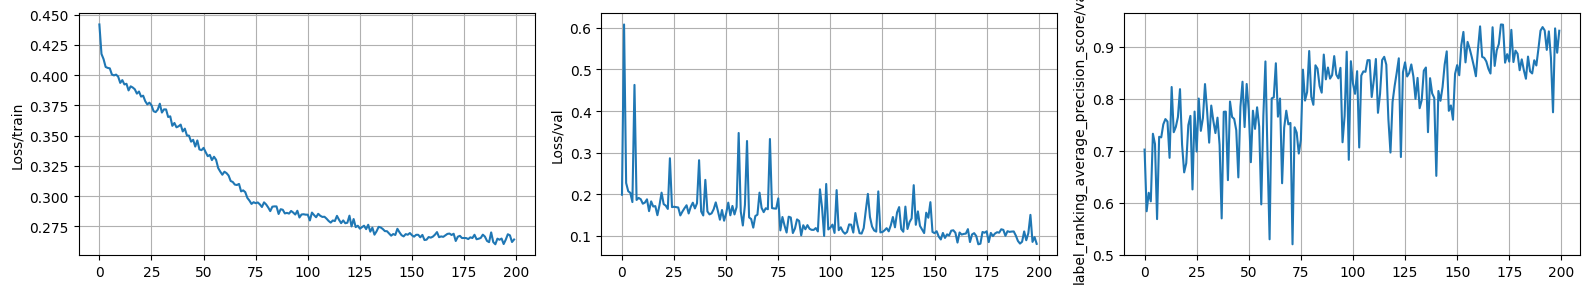

                  precision    recall  f1-score   support

          alkane       0.94      0.82      0.88      1622
          methyl       0.94      0.74      0.83      1480
          alkene       0.96      0.27      0.42       320
          alkyne       1.00      0.17      0.29        48
        alcohols       0.95      0.54      0.69       545
          amines       0.96      0.35      0.52       320
        nitriles       1.00      0.12      0.21        95
       aromatics       0.97      0.93      0.95      1378
    alkyl halides      0.90      0.43      0.58       604
          esters       0.96      0.37      0.53       270
         ketones       1.00      0.07      0.14       216
       aldehydes       1.00      0.14      0.24        51
    carboxylic acids   0.90      0.19      0.31       142
           ether       0.97      0.49      0.65       591
    acyl halides       0.00      0.00      0.00        26
          amides       1.00      0.06      0.12       171
           nitro       1.00      0.26      0.42       140

       micro avg       0.95      0.62      0.75      8019
       macro avg       0.91      0.35      0.46      8019
    weighted avg       0.95      0.62      0.71      8019
     samples avg       0.93      0.64      0.73      8019


hs = 30

##25.07.2023

Крупные модели уже не доучиваются. Сделал зависимость планировщика обучения от толщины сети как - шаг планировщика - 3*hidden_size,
всего epoch=13*hidden_size. Тогда планировщик будет обучаться 4 полных шага с понижением в 5 раз и треть обычного шага. Общее понижение - в 100 раз.

val_dataset (0.2 от исходного) используется при обучении.

hidden_size = 20

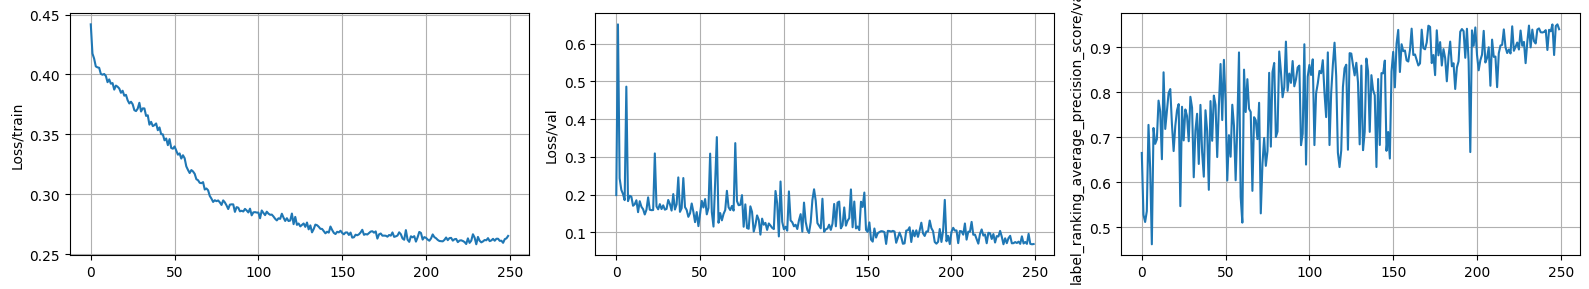

                  precision    recall  f1-score   support

          alkane       0.95      0.84      0.89       808
          methyl       0.95      0.74      0.83       738
          alkene       0.98      0.27      0.42       174
          alkyne       0.00      0.00      0.00        12
        alcohols       0.93      0.59      0.73       249
          amines       0.94      0.38      0.54       157
        nitriles       1.00      0.25      0.41        51
       aromatics       0.98      0.94      0.96       691
    alkyl halides      0.88      0.46      0.60       323
          esters       0.96      0.31      0.47       147
         ketones       1.00      0.05      0.10       119
       aldehydes       1.00      0.05      0.09        21
    carboxylic acids   0.91      0.16      0.28        61
           ether       0.98      0.54      0.70       313
    acyl halides       0.00      0.00      0.00        10
          amides       1.00      0.07      0.14        82
           nitro       0.97      0.46      0.62        70

       micro avg       0.95      0.64      0.76      4026
       macro avg       0.85      0.36      0.46      4026
    weighted avg       0.95      0.64      0.73      4026
     samples avg       0.93      0.66      0.75      4026

Из статистики понятно, что модель обучается хорошо. Но слабо берет наименьшие классы. Возможно, что требуется увеличение толщины сети.

hidden_size = 30

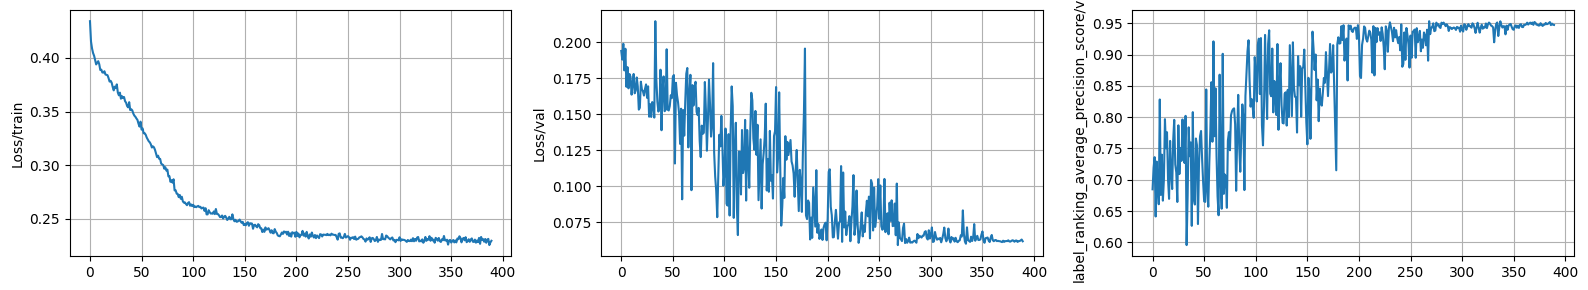

                  precision    recall  f1-score   support

          alkane       0.95      0.86      0.90       808
          methyl       0.94      0.80      0.87       738
          alkene       0.96      0.40      0.57       174
          alkyne       1.00      0.17      0.29        12
        alcohols       0.97      0.69      0.80       249
          amines       0.93      0.55      0.69       157
        nitriles       1.00      0.37      0.54        51
       aromatics       0.97      0.94      0.96       691
    alkyl halides      0.88      0.53      0.66       323
          esters       0.99      0.52      0.68       147
         ketones       0.94      0.28      0.43       119
       aldehydes       1.00      0.33      0.50        21
    carboxylic acids   0.91      0.33      0.48        61
           ether       0.97      0.68      0.80       313
    acyl halides       0.00      0.00      0.00        10
          amides       0.79      0.13      0.23        82
           nitro       0.97      0.54      0.70        70

       micro avg       0.95      0.71      0.81      4026
       macro avg       0.89      0.48      0.59      4026
    weighted avg       0.95      0.71      0.79      4026
     samples avg       0.93      0.73      0.79      4026

Обучение hidden_size 50 слишком долгое при предыдущих параметрах. Планировщик уменьшаем шаг до 2*hs и всего
6*hs эпох

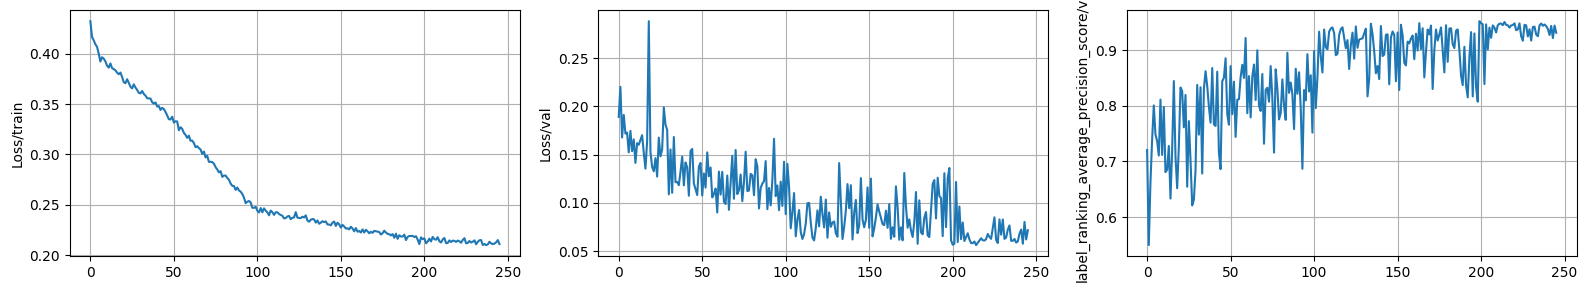

Обучение не завершено.

## 27.07.2023

Нормирование для трейна осуществлено до обучения, а для теста и валидации в процессе.
v0.8.1.gl5n - обучение на заранее нормированных данных

Переобучение начинается для толщине 30 при 80 эпохах

hs=10

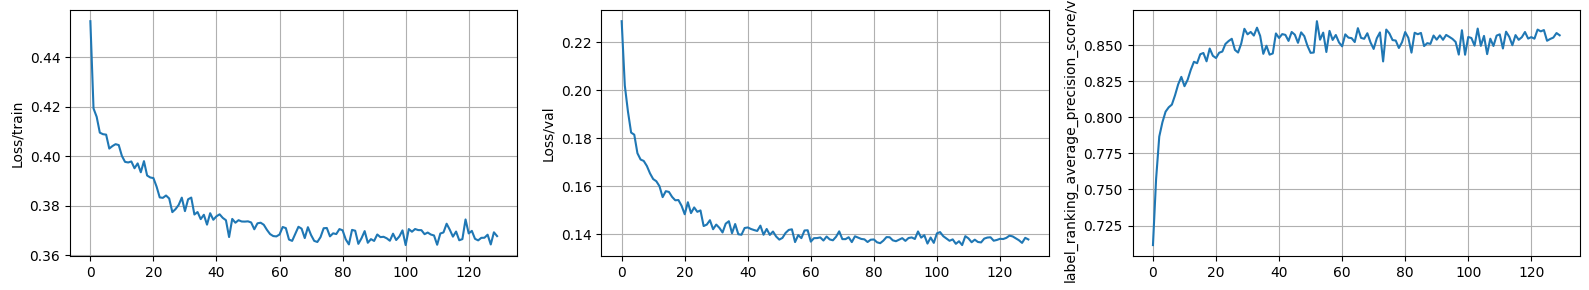

  weighted avg       0.82      0.34      0.44      4005 - подхватывает не все.

hs = 30

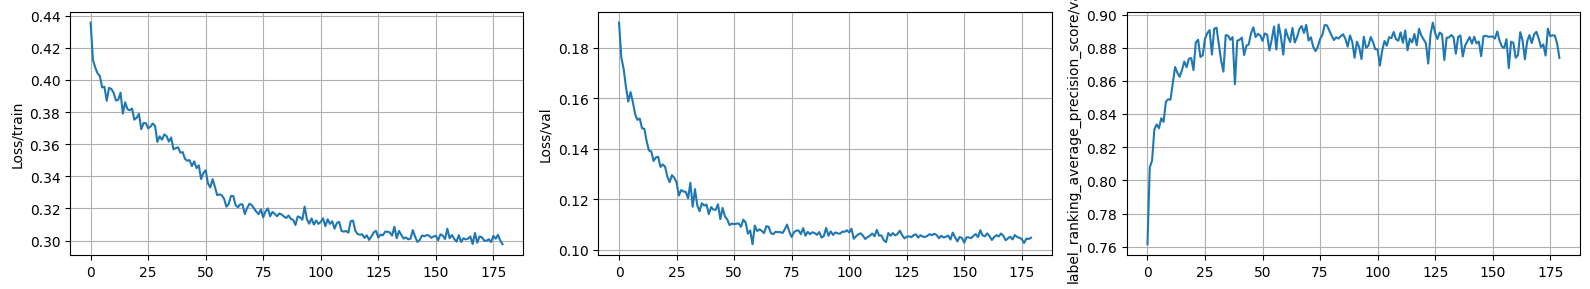

                  precision    recall  f1-score   support

          alkane       0.93      0.79      0.86       826
          methyl       0.88      0.75      0.81       730
          alkene       0.89      0.24      0.38       166
          alkyne       0.83      0.25      0.38        20
        alcohols       0.91      0.52      0.67       260
          amines       0.93      0.36      0.52       158
        nitriles       1.00      0.13      0.23        55
       aromatics       0.95      0.89      0.92       674
    alkyl halides      0.86      0.30      0.44       291
          esters       0.98      0.34      0.50       139
         ketones       1.00      0.05      0.09       107
       aldehydes       1.00      0.12      0.22        32
    carboxylic acids   0.88      0.19      0.31        74
           ether       0.94      0.49      0.64       300
    acyl halides       0.00      0.00      0.00         7
          amides       0.88      0.08      0.15        86
           nitro       1.00      0.10      0.18        80

       micro avg       0.92      0.59      0.72      4005
       macro avg       0.87      0.33      0.43      4005
    weighted avg       0.92      0.59      0.68      4005
     samples avg       0.90      0.61      0.70      4005

Подхватывает почти все (кроме 1), но плохо. Надо увеличить толщину.

Уже лучше. hs = 50 0,74. Тоже не берет 1 одну полосу.

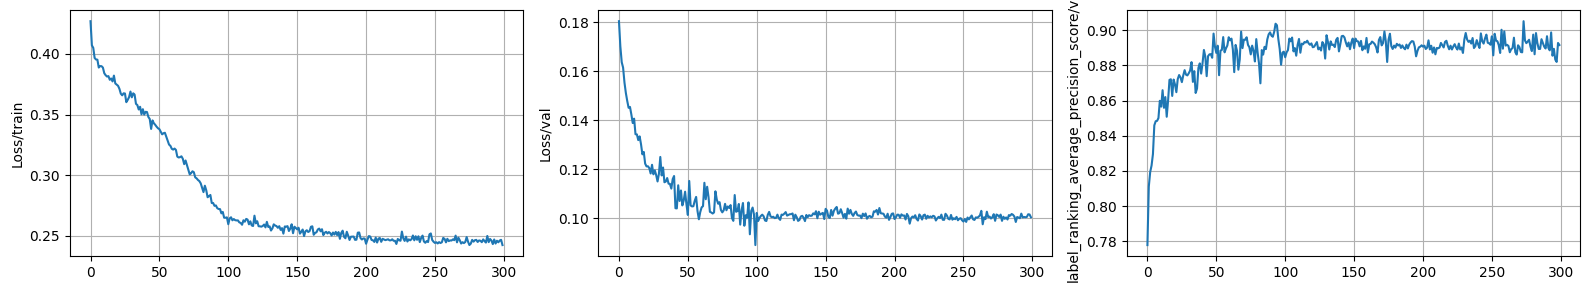

                precision    recall  f1-score   support

          alkane       0.91      0.83      0.87       826
          methyl       0.88      0.80      0.84       730
          alkene       0.95      0.34      0.50       166
          alkyne       0.88      0.35      0.50        20
        alcohols       0.91      0.67      0.77       260
          amines       0.85      0.35      0.50       158
        nitriles       0.93      0.24      0.38        55
       aromatics       0.96      0.90      0.93       674
    alkyl halides      0.77      0.38      0.51       291
          esters       0.95      0.50      0.65       139
         ketones       0.89      0.23      0.37       107
       aldehydes       1.00      0.41      0.58        32
    carboxylic acids   0.85      0.31      0.46        74
           ether       0.97      0.60      0.74       300
    acyl halides       0.00      0.00      0.00         7
          amides       0.73      0.22      0.34        86
           nitro       0.90      0.24      0.38        80

       micro avg       0.91      0.66      0.76      4005
       macro avg       0.84      0.43      0.55      4005
    weighted avg       0.90      0.66      0.74      4005
     samples avg       0.90      0.68      0.74      4005


##28.07.2023

Поменян местами последний дропаут. Теперь он после активации.

v0.8.2.gl5n

на 200 эпохах переобучение(

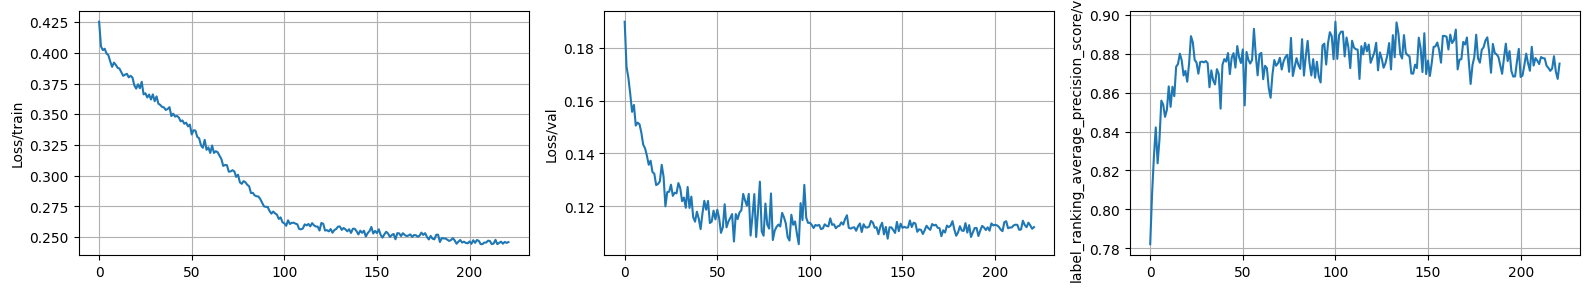

                 precision    recall  f1-score   support

          alkane       0.91      0.83      0.87       826
          methyl       0.89      0.78      0.83       730
          alkene       0.92      0.36      0.52       166
          alkyne       0.89      0.40      0.55        20
        alcohols       0.91      0.62      0.74       260
          amines       0.88      0.38      0.53       158
        nitriles       0.90      0.16      0.28        55
       aromatics       0.96      0.91      0.93       674
    alkyl halides      0.77      0.35      0.48       291
          esters       0.96      0.47      0.63       139
         ketones       0.95      0.17      0.29       107
       aldehydes       1.00      0.28      0.44        32
    carboxylic acids   0.85      0.46      0.60        74
           ether       0.93      0.60      0.73       300
    acyl halides       0.00      0.00      0.00         7
          amides       0.85      0.26      0.39        86
           nitro       1.00      0.19      0.32        80

       micro avg       0.91      0.65      0.76      4005
       macro avg       0.86      0.42      0.54      4005
    weighted avg       0.90      0.65      0.73      4005
     samples avg       0.90      0.67      0.74      4005

v0.8.3.gl5n - увеличение дропаута

## 01.08.2023


Воспроизводство 5,1


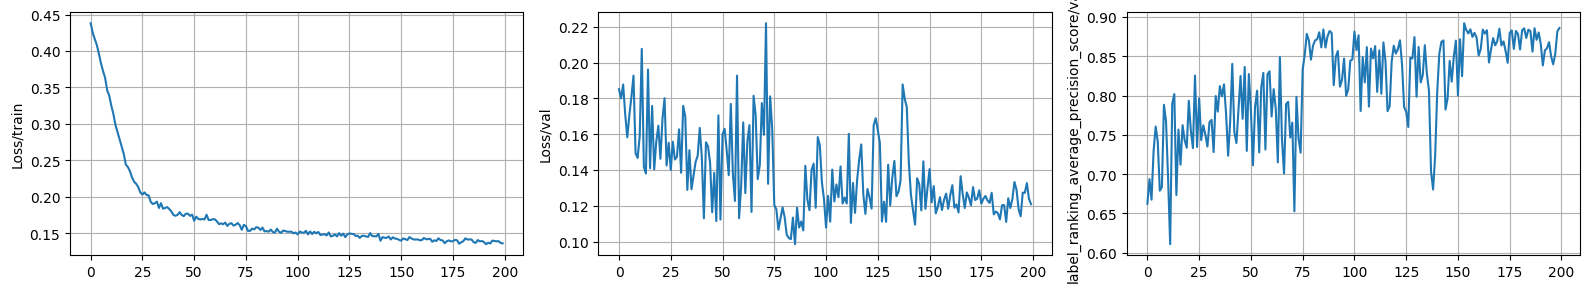

                  precision    recall  f1-score   support

          alkane       0.89      0.87      0.88       826
          methyl       0.88      0.81      0.85       730
          alkene       0.89      0.44      0.59       166
          alkyne       0.75      0.15      0.25        20
        alcohols       0.87      0.63      0.73       260
          amines       0.92      0.43      0.59       158
        nitriles       1.00      0.07      0.14        55
       aromatics       0.94      0.94      0.94       674
    alkyl halides      0.81      0.36      0.50       291
          esters       0.95      0.58      0.72       139
         ketones       0.92      0.34      0.49       107
       aldehydes       0.00      0.00      0.00        32
    carboxylic acids   0.88      0.47      0.61        74
           ether       0.92      0.64      0.75       300
    acyl halides       0.00      0.00      0.00         7
          amides       0.79      0.38      0.52        86
           nitro       0.95      0.24      0.38        80

       micro avg       0.90      0.69      0.78      4005
       macro avg       0.79      0.43      0.53      4005
    weighted avg       0.89      0.69      0.75      4005
     samples avg       0.89      0.70      0.76      4005

# Конец